# Install Required Packages

In [2]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 5.6 MB/s eta 0:00:00


In [3]:
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Library initialization

In [56]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest ,  f_classif
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score,auc, roc_curve, roc_auc_score,confusion_matrix,classification_report, make_scorer
from matplotlib.pyplot import figure
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import warnings
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import svm
from sklearn.model_selection import StratifiedKFold
import time
from itertools import cycle
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns  # plotting
from scipy import stats
from prettytable import PrettyTable  # To print in tabular format
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_validate, cross_val_predict
from yellowbrick.classifier.rocauc import roc_auc
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
import scipy
%matplotlib inline

warnings.filterwarnings("ignore")

# Define Classes

##### *Visualisation Class*

In [57]:
class Visualizations_Class:
    def plot_heatmap(self, x):
        colormap = plt.cm.viridis
        plt.figure(figsize=(30,30))
        sns.heatmap(x.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, annot=True)


    def plot_Histogram(self, feature_name, dataFrameName):
      sns.set(style='ticks', palette='bright', font_scale=1)
      fig, ax=plt.subplots(figsize=(2,2))
      plt.hist(dataFrameName[feature_name], bins=15, color='b')
      plt.xlabel(feature_name)
      plt.ylabel('count')
      plt.show()

    def plot_scatteredplot(self, feature_name1,feature_name2, dataFrameName):
      fig, ax=plt.subplots(figsize=(2,2))
      plt.scatter(dataFrameName[feature_name1],dataFrameName[feature_name2],s=10,c='g')
      plt.xlabel(feature_name1)
      plt.ylabel(feature_name2)
      plt.show()

    def plot_outliers(self,feature_name):
        sns.boxplot(df_main[feature_name])
        plt.show()

##### *Utility Class*

In [58]:
class Utility:
    
    def redefine_target_feature(self, x):
        print('\033[1m' + '\n Redifining the Target Feature to :\n 0 - Normal, 1 - Prediabetic, 2 - diabetic: \n' + '\033[0m')
        # 0 - Normal, 1 - Prediabetic, 2 - diabetic
        df_diabetes_final = x
        df_diabetes_final.loc[df_diabetes_final['LBXGH'] < 5.7, 'Diabetes'] = 0
        df_diabetes_final.loc[(df_diabetes_final['LBXGH'] >= 5.7) & (df_diabetes_final['LBXGH'] <= 6.4), 'Diabetes'] = 1
        df_diabetes_final.loc[df_diabetes_final['LBXGH'] >= 6.5, 'Diabetes'] = 2
        return df_diabetes_final

    def check_for_nulls_per(self, x):
        table = {'\033[1m' + '\n Null Values By Count \n' + '\033[0m' :  x.isna().sum().sort_values(ascending=True),
                 '\033[1m' + '\n Null Values By Percentage \n' + '\033[0m': round((x.isnull().sum() * 100/ len(x)),2).sort_values(ascending=True),
            }
        table_df = pd.DataFrame(table)
        with pd.option_context('display.max_rows', None,):
            print(table_df)
        
        
    def treat_by_lambda(self, x, column_names):
        for col in column_names:
            x[col] = x[col].apply(lambda i: i if i > 0 else 0)

        return x

    def treat_by_mode(self, x, column_names):
        for col in column_names:
            x[col] = x[col].fillna(x[col].mode()[0])

        return x

    def treat_by_median(self, x, column_names):
        for col in column_names:
          x[col] = x[col].fillna(x[col].median())
        
        return x

    def treat_outlier_by_median(self, x, column_names):
        for col in column_names:
          for i in x[col]:
            q1 = x[col].quantile(0.25)
            q3 = x[col].quantile(0.75)
            iqr = q3-q1
            lower_tail = q1 - 1.5*iqr
            upper_tail = q3 + 1.5*iqr
            if i>upper_tail or i<lower_tail:
              x[col] = x[col].replace(i,x[col].median())
        return x

    def treat_by_one(self, x, column_names):
        for col in column_names:
            x[col] = x[col].fillna(value = 1)

        return x

    def treat_by_value(self, x, column_names,value):
        for col in column_names:
            x[col] = x[col].fillna(value = value)

        return x

    def treat_by_mean(self, x, column_names):
        for col in column_names:
            x[col] = x[col].fillna(x[col].mean())

        return x

    def treat_by_ffil(self, x, column_names):
        for col in column_names:
            x[col] = x[col].fillna(method='ffill')

        return x
    
    def corr_matrix_abs(self, x):
        corr_matrix = x.corr().abs() # Create correlation matrix
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)) # Select upper triangle of correlation matrix
        to_drop = [column for column in upper.columns if any(upper[column] > 0.80)] # Find features with correlation greater than 0.80
        x.drop(to_drop, axis=1, inplace=True) # Drop  
        return x

    def select_best_40_features(self, x):
        corr_matrix = x.corr() # Compute the correlation matrix
        pos_corr_cols = corr_matrix.nlargest(20, "LBXGH")["LBXGH"].index.tolist() # Select the top 20 most positively correlated columns
        neg_corr_cols = corr_matrix.nsmallest(20, "LBXGH")["LBXGH"].index.tolist() # Select the top 20 most negatively correlated columns
        selected_cols = pos_corr_cols + neg_corr_cols # Combine the lists of positively and negatively correlated columns
        selected_cols.append('SEQN')
        x = x[selected_cols]
        return x

    def check_correlation_matrix(self, x):
        corr_matrix = x.corr()
        print(corr_matrix["LBXGH"].sort_values(ascending=False))
    
    def save_file_csv(self, x, file_name):
        # folder_path = '/content/drive/Shared drives/Data Mining Project/Data Mining Project/Cleaned Data/'
        #folder_path = '/content/drive/MyDrive/Data Mining Project/Cleaned Data/'
        # file_name = folder_path + file_name
        # file_path = os.path.join(folder_path, file_name)
        x.to_csv(file_name, index=False, encoding="utf-8")

    def remove_40_perc_null_features(self, x):
        null_percentage = (x.isnull().sum() / len(x)) * 100
        null_columns = list(null_percentage[null_percentage >= 40].index)
        x = x.drop(null_columns, axis=1)
        print('\033[1m' + '\n Dropping ',len(null_columns),'features \n' + '\033[0m')
        return x

    def standardscaling(self, X_train, X_test):
      scaler = StandardScaler()
      scaler.fit(X_train)

      # transform the training and testing data
      X_train = scaler.transform(X_train)
      X_test = scaler.transform(X_test)
      return X_train, X_test

    def minmaxscaling(self, X_train, X_test):
      scaler = MinMaxScaler()
      scaler.fit(X_train)

      # transform the training and testing data
      X_train = scaler.transform(X_train)
      X_test = scaler.transform(X_test)
      return X_train, X_test

##### *Feature importance Class*

In [59]:
class Feature_Importance:

    def __init__(self, n=20):
        self.n = n

    

    def feature_imp(self, model_name, model, X_train):
        
        if model_name == 'CatBoostClassifier':
            feat_imp = model.get_feature_importance()
            feat_imp_sort = np.argsort(feat_imp)[::-1]
            feature_names = X_train.columns[feat_imp_sort]
            feature_scores = feat_imp[feat_imp_sort]
        elif model_name == 'XGBClassifier':
            feat_imp = model.feature_importances_
            feat_imp_sort = np.argsort(feat_imp)[::-1]
            feature_names = X_train.columns[feat_imp_sort]
            feature_scores = feat_imp[feat_imp_sort]
        elif model_name == 'RandomForestClassifier' or model_name == 'ExtraTreesClassifier':
            feat_imp = model.feature_importances_
            feat_imp_sort = np.argsort(feat_imp)[::-1]
            feature_names = X_train.columns[feat_imp_sort]
            feature_scores = feat_imp[feat_imp_sort]
        elif model_name == 'LogisticRegression':
            feat_imp_sort = np.argsort(np.abs(model.coef_))[0][::-1]
            feature_names = X_train.columns[feat_imp_sort]
            feature_scores = np.abs(model.coef_[0][feat_imp_sort])
        elif model_name == 'DecisionTreeClassifier_RFE':
            feat_imp_sort = np.argsort(model.estimator_.feature_importances_)[::-1]
            feature_names = X_train.columns[feat_imp_sort]
            feature_scores = model.estimator_.feature_importances_[feat_imp_sort]
        elif model_name == 'chi-squared':
            select_k_best = SelectKBest(chi2, k='all')
            select_k_best.fit(X_train, y_train)
            X_axis = X_train.columns
            Y_axis = select_k_best.scores_
            feat_imp_sort = np.argsort(Y_axis)[::-1]
            feature_names = X_axis[feat_imp_sort]
            feature_scores = Y_axis[feat_imp_sort]
        elif model_name == 'anova':
            select_k_best = SelectKBest(f_classif, k=20)
            select_k_best.fit(X_train, y_train)
            X_axis = X_train.columns
            Y_axis = select_k_best.scores_
            feat_imp_sort = np.argsort(Y_axis)[::-1]
            feature_names = X_axis[feat_imp_sort]
            feature_scores = Y_axis[feat_imp_sort]
        else:
            raise ValueError('Invalid method specified.')
            
        print('\033[1m' + '\n The most important 20 features for ' + model_name + ': \n' + '\033[0m')
        names = []
        for i in range(20):
            print(i+1, '-', feature_names[i], ': ', feature_scores[i])
            names.append(feature_names[i])

        print('\033[1m')
        print(f"Plotting the Feature Importance Graph for the {model_name} :")
        print('\033[0m')
        figure(figsize=(15, 10), dpi=80)
        plt.barh(feature_names, feature_scores, color='teal')
        plt.title("Feature Importance - Top 20 Features", fontweight='bold')
        plt.grid(False)
        plt.show()
        return names




        
        
        
    def train_model(self, model_name, X_train, y_train):
        model = None # assign None to model variable
        seed = 2023
        if model_name == 'CatBoostClassifier':
            model = CatBoostClassifier(verbose=False, random_state=seed)
        elif model_name == 'XGBClassifier':
            model = XGBClassifier(random_state=seed)
        elif model_name == 'RandomForestClassifier':
            model = RandomForestClassifier(random_state=seed)
        elif model_name == 'ExtraTreesClassifier':
            model = ExtraTreesClassifier(random_state=seed)
        elif model_name == 'LogisticRegression':
            model = LogisticRegression(max_iter=1000,random_state=seed)
        elif model_name == 'DecisionTreeClassifier_RFE':
          dt = DecisionTreeClassifier(random_state=seed)
          rfe = RFE(estimator=dt, n_features_to_select=self.n, step=1)
          model = rfe.fit(X_train, y_train)
        elif model_name == 'chi-squared':
          select_k_best = SelectKBest(chi2, k='all')
          select_k_best.fit(X_train, y_train)
          X_train = select_k_best.transform(X_train)
        elif model_name == 'anova':
          select_k_best_anova = SelectKBest(f_classif, k=20)
          select_k_best_anova.fit(X_train, y_train)
          X_train = select_k_best_anova.transform(X_train)
          
        
          
        else:
          raise ValueError("Invalid model name.")

        if model is not None:
          model.fit(X_train, y_train)

        return model

##### *Data Modeling Class*

In [60]:
class data_modeling:
  def model_training(self, model_name, X_train, y_train, X_test, y_test):
    seed = 2023
    if model_name == 'RandomForestClassifier':
      model = RandomForestClassifier(random_state=seed,n_jobs=-1)
      params = {'criterion':['gini','entropy'],
            'ccp_alpha':[0,1,2]
         }
      tuned_clf = self.hyperparam_tuning_new(model,params,X_train, y_train,cv=5)
      print("Best Parameters: ", tuned_clf.best_params_)
      print("Best Score: ", tuned_clf.best_score_)
      print("Standard Deviation: ", tuned_clf.cv_results_['std_test_accuracy'][tuned_clf.best_index_])
      self.plot(tuned_clf, model_name, X_train, y_train, X_test, y_test)

    elif model_name == 'LogisticRegression':
      model = LogisticRegression(random_state=seed)
      params = {'penalty':['l1','l2','elasticnet'],
            'C':[1.0,2.0,3.0]
         }
      tuned_clf = self.hyperparam_tuning_new(model,params,X_train, y_train,cv=5)
      print("Best Parameters: ", tuned_clf.best_params_)
      print("Best Score: ", tuned_clf.best_score_)
      print("Standard Deviation: ", tuned_clf.cv_results_['std_test_accuracy'][tuned_clf.best_index_])
      self.plot(tuned_clf, model_name, X_train, y_train, X_test, y_test)

    elif model_name == 'KNN':
      model = KNeighborsClassifier()
      params = {
            'n_neighbors':[1,2,3,4,5,6,7,8,9,10]
         }
      tuned_clf = self.hyperparam_tuning_new(model,params,X_train, y_train,cv=5)
      print("Best Parameters: ", tuned_clf.best_params_)
      print("Best Score: ", tuned_clf.best_score_)
      print("Standard Deviation: ", tuned_clf.cv_results_['std_test_accuracy'][tuned_clf.best_index_])
      self.plot(tuned_clf, model_name, X_train, y_train, X_test, y_test)

    elif model_name == 'SVM':
      model = svm.SVC(random_state=seed)
      params = {'kernel':['rbf','linear','poly'],
            'C':[1.0,2.0,3.0]
         }
      tuned_clf = self.hyperparam_tuning_new(model,params,X_train, y_train,cv=5)
      print("Best Parameters: ", tuned_clf.best_params_)
      print("Best Score: ", tuned_clf.best_score_)
      print("Standard Deviation: ", tuned_clf.cv_results_['std_test_accuracy'][tuned_clf.best_index_])
      self.plot(tuned_clf, model_name, X_train, y_train, X_test, y_test)

    else:
      print("No model defined")
      return
    
    
    
  def model_training_FE(self, model_name, X_train, y_train, X_test, y_test):
    seed = 2023
    if model_name == 'DecisionTreeClassifier':
      model = DecisionTreeClassifier(random_state=seed)
      model.fit(X_train, y_train)
      self.plot(model, model_name, X_train, y_train, X_test, y_test)

    elif model_name == 'RandomForestClassifier':
      model = RandomForestClassifier(random_state=seed,n_jobs=-1,criterion='entropy',ccp_alpha=0 )
      model.fit(X_train, y_train)
      self.plot(model, model_name, X_train, y_train, X_test, y_test)

    elif model_name == 'LogisticRegression':
      model = LogisticRegression(random_state=seed,penalty='l2',C=3.0)
      model.fit(X_train, y_train)
      self.plot(model, model_name, X_train, y_train, X_test, y_test)

    elif model_name == 'KNN':
      model = KNeighborsClassifier(n_neighbors=1)
      model.fit(X_train, y_train)
      self.plot(model, model_name, X_train, y_train, X_test, y_test)

    elif model_name == 'SVM':
      model = svm.SVC(random_state=seed,kernel='poly',C=3.0)
      model.fit(X_train, y_train)
      self.plot(model, model_name, X_train, y_train, X_test, y_test)

    else:
      print("No model defined")
      return
    
    

  def plot(self, model, model_name, X_train, y_train, X_test, y_test):
    np.set_printoptions(precision=2)
    pred = model.predict(X_test)
    class_names = ['0', '1','2']
    f1 = f1_score(y_test, pred, average='micro')
    acc_score = accuracy_score(y_test, pred) * 100
    print(classification_report(y_test, pred, target_names=class_names))

    roc_auc(model, X_train, y_train, X_test=X_test, y_test=y_test, classes=class_names)
    # Plot non-normalized confusion matrix
    titles_options = [
        ("Confusion matrix, without normalization", None),
        ("Normalized confusion matrix", "true"),
    ]
    for title, normalize in titles_options:
        disp = ConfusionMatrixDisplay.from_estimator(
            model,
            X_test,
            y_test,
            display_labels=class_names,
            cmap=plt.cm.Blues,
            normalize=normalize,
        )
        disp.ax_.set_title(title)
        plt.grid(False)
        plt.show()


  def hyperparam_tuning_new(self, clf, parameters, x, y, method='gridsearch', cv=None):
    """
    Utility function for Tuning hyperparameters
    """
    # initialization
    scoring = {'accuracy':'accuracy',
               'f1':'f1',
               'precision':'precision',
               'recall':'recall'}
                
    # param tuning
    if method=='gridsearch':
        # As we are using multi scoring, So we need to point refit to scoring function with which we want to evaluate score
        tuning_clf = GridSearchCV(clf, parameters, scoring=scoring,verbose=0,refit='accuracy',
                                  cv=cv)
        result = tuning_clf.fit(x, y)
    
    elif method=='randomsearch':
        tuning_clf = RandomizedSearchCV(clf, parameters, scoring=scoring,verbose=0,refit='accuracy',
                                        cv=cv)
        result = tuning_clf.fit(x, y)

    return result


# Create Class Object

In [61]:
func = Utility()
feature_imp = Feature_Importance()
viz = Visualizations_Class()
cls_model_obj = data_modeling()

# EDA

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [94]:
df_main = pd.read_csv('/content/drive/MyDrive/NHANES_Categorical_Merged_2013_14.csv')
df_main.head(5)

SEQN  SDDSRVYR  RIDSTATR  RIAGENDR  RIDAGEYR  RIDAGEMN  RIDRETH1  \
0  73557         8         2         1        69       NaN         4   
1  73557         8         2         1        69       NaN         4   
2  73558         8         2         1        54       NaN         3   
3  73558         8         2         1        54       NaN         3   
4  73558         8         2         1        54       NaN         3   

   RIDRETH3  RIDEXMON  RIDEXAGM  ...  WHD080U  WHD080L  WHD110  WHD120  \
0         4         1       NaN  ...      NaN     40.0   270.0   200.0   
1         4         1       NaN  ...      NaN     40.0   270.0   200.0   
2         3         1       NaN  ...      NaN      NaN   240.0   250.0   
3         3         1       NaN  ...      NaN      NaN   240.0   250.0   
4         3         1       NaN  ...      NaN      NaN   240.0   250.0   

   WHD130  WHD140  WHQ150  WHQ030M  WHQ500  WHQ520  
0    69.0   270.0    62.0      NaN     NaN     NaN  
1    69.0   270.0    62.0      NaN     NaN     NaN  
2    72.0   250.0    25.0      NaN     NaN     NaN  
3    72.0   250.0    25.0      NaN     NaN     NaN  
4    72.0   250.0    25.0      NaN     NaN     NaN  

[5 rows x 1825 columns]

# Data Cleaning:

## 1. Remove nulls in SEQN number


## 2. Remove duplicate SEQN number


In [95]:
df_main = df_main.dropna(subset=['SEQN'])
df_main = df_main.drop_duplicates(subset=['SEQN'])
df_main

SEQN  SDDSRVYR  RIDSTATR  RIAGENDR  RIDAGEYR  RIDAGEMN  RIDRETH1  \
0      73557         8         2         1        69       NaN         4   
2      73558         8         2         1        54       NaN         3   
6      73559         8         2         1        72       NaN         3   
11     73561         8         2         2        73       NaN         3   
15     73562         8         2         1        56       NaN         1   
...      ...       ...       ...       ...       ...       ...       ...   
15743  83721         8         2         1        52       NaN         3   
15744  83723         8         2         1        61       NaN         1   
15745  83724         8         2         1        80       NaN         3   
15750  83727         8         2         1        26       NaN         2   
15751  83729         8         2         2        42       NaN         4   

       RIDRETH3  RIDEXMON  RIDEXAGM  ...  WHD080U  WHD080L  WHD110  WHD120  \
0             4         1       NaN  ...      NaN     40.0   270.0   200.0   
2             3         1       NaN  ...      NaN      NaN   240.0   250.0   
6             3         2       NaN  ...      NaN      NaN   180.0   190.0   
11            3         1       NaN  ...      NaN      NaN   150.0   135.0   
15            1         1       NaN  ...      NaN      NaN   225.0   195.0   
...         ...       ...       ...  ...      ...      ...     ...     ...   
15743         3         1       NaN  ...      NaN      NaN   172.0   163.0   
15744         1         2       NaN  ...      NaN      NaN   240.0   200.0   
15745         3         1       NaN  ...      NaN      NaN   173.0   140.0   
15750         2         2       NaN  ...      NaN      NaN     NaN     NaN   
15751         4         2       NaN  ...      NaN      NaN   155.0   135.0   

       WHD130  WHD140  WHQ150  WHQ030M  WHQ500  WHQ520  
0        69.0   270.0    62.0      NaN     NaN     NaN  
2        72.0   250.0    25.0      NaN     NaN     NaN  
6        70.0   228.0    35.0      NaN     NaN     NaN  
11       67.0   170.0    60.0      NaN     NaN     NaN  
15       64.0   244.0    54.0      NaN     NaN     NaN  
...       ...     ...     ...      ...     ...     ...  
15743    70.0   181.0    45.0      NaN     NaN     NaN  
15744    69.0   245.0    61.0      NaN     NaN     NaN  
15745    71.0   190.0    55.0      NaN     NaN     NaN  
15750     NaN   150.0    26.0      NaN     NaN     NaN  
15751     NaN   195.0    42.0      NaN     NaN     NaN  

[6643 rows x 1825 columns]

## 3. Redefine target features based on Glycohemoglobin value 0 - Normal, 1 - Prediabetic, 2 - diabetic.

In [96]:
df_main = func.redefine_target_feature(df_main)
df_main


 Redifining the Target Feature to :
 0 - Normal, 1 - Prediabetic, 2 - diabetic: 



SEQN  SDDSRVYR  RIDSTATR  RIAGENDR  RIDAGEYR  RIDAGEMN  RIDRETH1  \
0      73557         8         2         1        69       NaN         4   
2      73558         8         2         1        54       NaN         3   
6      73559         8         2         1        72       NaN         3   
11     73561         8         2         2        73       NaN         3   
15     73562         8         2         1        56       NaN         1   
...      ...       ...       ...       ...       ...       ...       ...   
15743  83721         8         2         1        52       NaN         3   
15744  83723         8         2         1        61       NaN         1   
15745  83724         8         2         1        80       NaN         3   
15750  83727         8         2         1        26       NaN         2   
15751  83729         8         2         2        42       NaN         4   

       RIDRETH3  RIDEXMON  RIDEXAGM  ...  WHD080L  WHD110  WHD120  WHD130  \
0             4         1       NaN  ...     40.0   270.0   200.0    69.0   
2             3         1       NaN  ...      NaN   240.0   250.0    72.0   
6             3         2       NaN  ...      NaN   180.0   190.0    70.0   
11            3         1       NaN  ...      NaN   150.0   135.0    67.0   
15            1         1       NaN  ...      NaN   225.0   195.0    64.0   
...         ...       ...       ...  ...      ...     ...     ...     ...   
15743         3         1       NaN  ...      NaN   172.0   163.0    70.0   
15744         1         2       NaN  ...      NaN   240.0   200.0    69.0   
15745         3         1       NaN  ...      NaN   173.0   140.0    71.0   
15750         2         2       NaN  ...      NaN     NaN     NaN     NaN   
15751         4         2       NaN  ...      NaN   155.0   135.0     NaN   

       WHD140  WHQ150  WHQ030M  WHQ500  WHQ520  Diabetes  
0       270.0    62.0      NaN     NaN     NaN       2.0  
2       250.0    25.0      NaN     NaN     NaN       2.0  
6       228.0    35.0      NaN     NaN     NaN       2.0  
11      170.0    60.0      NaN     NaN     NaN       0.0  
15      244.0    54.0      NaN     NaN     NaN       0.0  
...       ...     ...      ...     ...     ...       ...  
15743   181.0    45.0      NaN     NaN     NaN       0.0  
15744   245.0    61.0      NaN     NaN     NaN       2.0  
15745   190.0    55.0      NaN     NaN     NaN       0.0  
15750   150.0    26.0      NaN     NaN     NaN       0.0  
15751   195.0    42.0      NaN     NaN     NaN       0.0  

[6643 rows x 1826 columns]

## 4. Select 35 features based on Domain knowledge that is proven to affect the Glycohemoglobin levels


In [97]:
df_main = df_main[['LBXSGL','LBXSTR','URXUMA','LBXSNASI','LBXSIR','MCQ080','MCQ300C','RIAGENDR','RIDAGEYR','RIDRETH3','DMDBORN4',
                                    'DR1TCARB','DR1TKCAL','DR1TPROT','DR1TSUGR',
                                    'DR1TFIBE',
                                    'DR1TTFAT',
                                    'DR1TSFAT',
                                    'DR1TMFAT',
                                    'DR1TPFAT',
                                    'DR1TCHOL',
                                    'BMXBMI',
                                    'MGDCGSZ',
                                    'BMDAVSAD',
                                    'BMXWAIST',
                                    'BMXARMC',
                                    'DR1TALCO',
                                    'DR1TCAFF',
                                    'DR1TIRON',
                                    'DR1TSODI',
                                    'INDFMIN2',
                                    'PAD680',
                                    'LBXRBCSI',
                                    'BPXSY2',
                                    'BPXDI2',
                                    'OHX30TC','Diabetes']]
                             
df_main.shape


(6643, 37)

## 5. Rename the features

In [98]:
df_main = df_main.rename(columns = {
                                    'LBXSGL': 'Glucose_lab',
                                    'LBXSTR': 'Triglycerides_lab',
                                    'URXUMA':'Albumin_urine_lab',
                                    'LBXSNASI' :'Sodium_lab',
                                    'LBXSIR': 'Iron_lab',
                                    'MCQ080': 'Overweight',
                                    'MCQ300C': 'Family_history',
                                    'RIAGENDR': 'Gender',
                                    'RIDAGEYR': 'Age',
                                    'RIDRETH3': 'Ethnicity',
                                    'DMDBORN4': 'Country_born',
                                    'DR1TCARB': 'Diet_Carb',
                                    'DR1TKCAL': 'Diet_Calories',
                                    'DR1TPROT': 'Diet_Protein',
                                    'DR1TSUGR': 'Diet_Sugar',
                                    'DR1TFIBE': 'Diet_Fiber',
                                    'DR1TTFAT': 'Diet_Fat',
                                    'DR1TSFAT': 'Diet_Saturated_Fat',
                                    'DR1TMFAT': 'Diet_Mono_Fat',
                                    'DR1TPFAT': 'Diet_Poly_Fat',
                                    'DR1TCHOL': 'Diet_Cholestrol',
                                    'BMXBMI': 'BMI',
                                    'MGDCGSZ': 'Grip_Strength',
                                    'BMDAVSAD': 'Abdominal_Diameter',
                                    'BMXWAIST': 'Waist_Circumference',
                                    'BMXARMC': 'Arm_Circumference',
                                    'DR1TALCO':'Diet_Alcohol',
                                    'DR1TCAFF':'Diet_Caffiene',
                                    'DR1TIRON':'Diet_Iron',
                                    'DR1TSODI':'Diet_Sodium',
                                    'INDFMIN2':'Annual_Income',
                                    'PAD680':'Sedentary',
                                    'LBXRBCSI':'RBC_Count',
                                    'BPXSY2':'BP_Sys',
                                    'BPXDI2':'BP_Dia',
                                    'OHX30TC': 'TC_LR_1Molar',
                                })

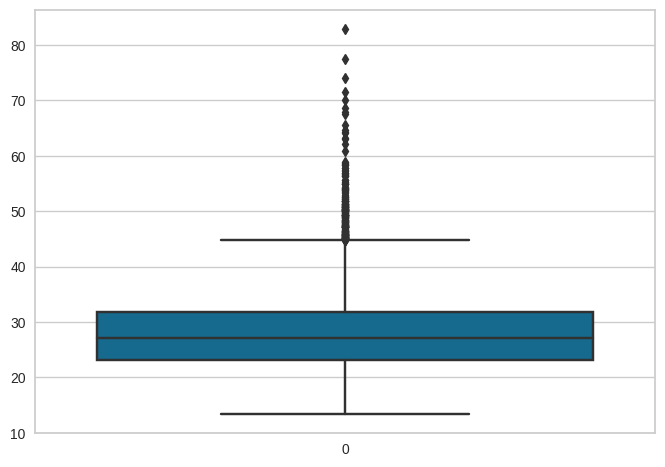

In [91]:
#viz.plot_outliers('BMI')
feature_name = 'BMI'
sns.boxplot(df_main[feature_name])
plt.show()


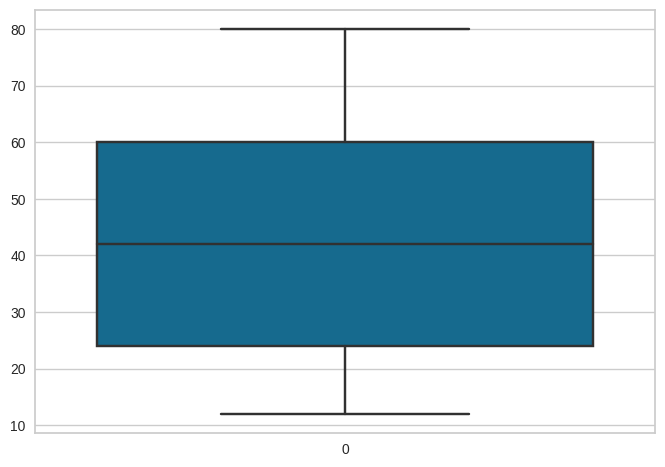

In [474]:
feature_name = 'Age'
sns.boxplot(df_main[feature_name])
plt.show()

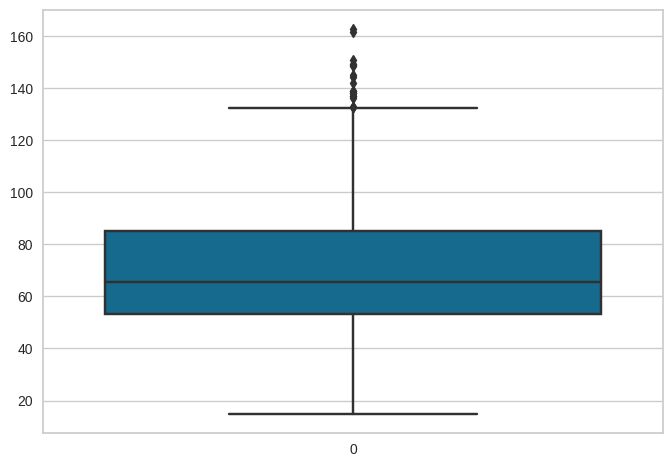

In [475]:
feature_name = 'Grip_Strength'
sns.boxplot(df_main[feature_name])
plt.show()

## 6. Treat the mising values for continious variables


## 7. Treat the mising values for categorical variables

In [99]:
print (round((df_main.isnull().sum() * 100/ len(df_main)),2).sort_values(ascending=False))

Family_history         18.83
Overweight              9.66
Diet_Mono_Fat           8.41
Diet_Calories           8.41
Diet_Caffiene           8.41
Diet_Cholestrol         8.41
Diet_Poly_Fat           8.41
Diet_Saturated_Fat      8.41
Diet_Fat                8.41
Diet_Fiber              8.41
Diet_Sugar              8.41
Diet_Alcohol            8.41
Diet_Protein            8.41
Diet_Carb               8.41
Diet_Iron               8.41
Diet_Sodium             8.41
Grip_Strength           7.68
Abdominal_Diameter      7.33
TC_LR_1Molar            5.48
BP_Sys                  5.01
BP_Dia                  5.01
Waist_Circumference     4.74
Arm_Circumference       3.82
Iron_lab                1.82
Albumin_urine_lab       1.58
Triglycerides_lab       1.49
Glucose_lab             1.43
Sodium_lab              1.43
Annual_Income           1.17
BMI                     1.13
Sedentary               0.45
RBC_Count               0.08
Country_born            0.00
Ethnicity               0.00
Age           

In [105]:
featuresTreatedByMedian = ['Glucose_lab','Triglycerides_lab','Albumin_urine_lab','Sodium_lab','Iron_lab','Diet_Carb','Diet_Calories','Diet_Protein','Diet_Sugar',
                           'Diet_Fiber','Diet_Fat','Diet_Saturated_Fat','Diet_Mono_Fat','Diet_Poly_Fat','Diet_Cholestrol','BMI','Grip_Strength','Abdominal_Diameter','Waist_Circumference',
                           'Arm_Circumference','Diet_Alcohol','Diet_Caffiene','Diet_Iron','Diet_Sodium','Annual_Income','RBC_Count','BP_Sys','BP_Dia','TC_LR_1Molar','Sedentary']

features_by_value = ['Overweight','Family_history']

In [106]:
df_main = func.treat_by_median(df_main, featuresTreatedByMedian)
df_main = func.treat_by_value(df_main, features_by_value,9)

In [71]:
featuresTreatedByMedian_Outliers = ['Glucose_lab','Triglycerides_lab','Albumin_urine_lab','Sodium_lab','Iron_lab','Diet_Carb','Diet_Calories','Diet_Protein','Diet_Sugar',
                           'Diet_Fiber','Diet_Fat','Diet_Saturated_Fat','Diet_Mono_Fat','Diet_Poly_Fat','Diet_Cholestrol','BMI','Grip_Strength','Abdominal_Diameter','Waist_Circumference',
                           'Arm_Circumference','Diet_Caffiene','Diet_Iron','Diet_Sodium','Annual_Income','RBC_Count','BP_Sys','BP_Dia']

df_main = func.treat_outlier_by_median(df_main, featuresTreatedByMedian_Outliers)                           

In [107]:
print (round((df_main.isnull().sum() * 100/ len(df_main)),2).sort_values(ascending=False))

Glucose_lab            0.0
Diet_Poly_Fat          0.0
BMI                    0.0
Grip_Strength          0.0
Abdominal_Diameter     0.0
Waist_Circumference    0.0
Arm_Circumference      0.0
Diet_Alcohol           0.0
Diet_Caffiene          0.0
Diet_Iron              0.0
Diet_Sodium            0.0
Annual_Income          0.0
Sedentary              0.0
RBC_Count              0.0
BP_Sys                 0.0
BP_Dia                 0.0
TC_LR_1Molar           0.0
Diet_Cholestrol        0.0
Diet_Mono_Fat          0.0
Triglycerides_lab      0.0
Diet_Saturated_Fat     0.0
Albumin_urine_lab      0.0
Sodium_lab             0.0
Iron_lab               0.0
Overweight             0.0
Family_history         0.0
Gender                 0.0
Age                    0.0
Ethnicity              0.0
Country_born           0.0
Diet_Carb              0.0
Diet_Calories          0.0
Diet_Protein           0.0
Diet_Sugar             0.0
Diet_Fiber             0.0
Diet_Fat               0.0
Diabetes               0.0
d

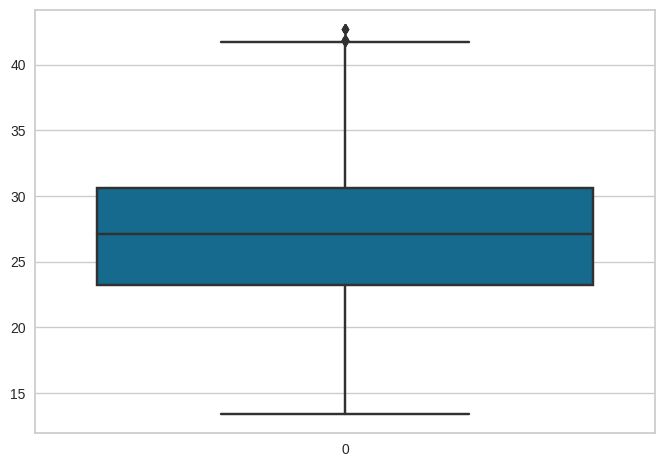

In [73]:
feature_name = 'BMI'
sns.boxplot(df_main[feature_name])
plt.show()

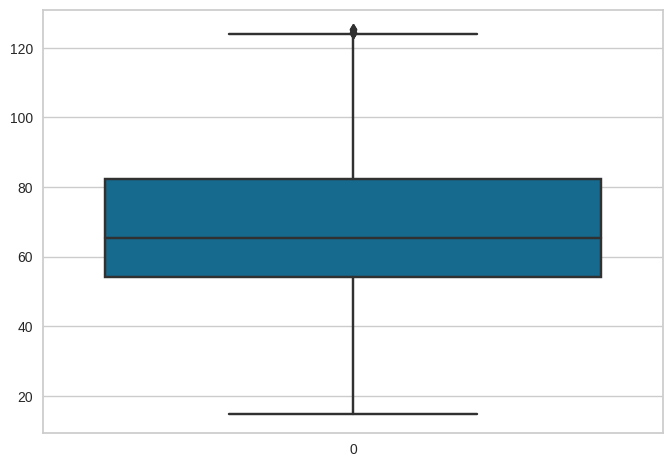

In [23]:
feature_name = 'Grip_Strength'
sns.boxplot(df_main[feature_name])
plt.show()

## 8. Fixing Class Imbalance

<Axes: xlabel='Diabetes', ylabel='Count'>

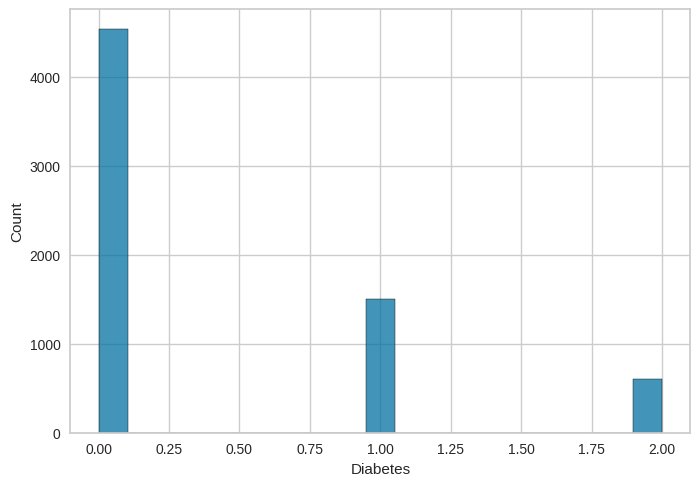

In [108]:
sns.histplot(data=df_main, x="Diabetes")

In [109]:
input_data = df_main.drop(['Diabetes'], axis=1)
input_data.head(2)

Glucose_lab  Triglycerides_lab  Albumin_urine_lab  Sodium_lab  Iron_lab  \
0        554.0              140.0                4.3       136.0      58.0   
2        219.0              257.0              153.0       128.0      79.0   

   Overweight  Family_history  Gender  Age  Ethnicity  ...  Diet_Alcohol  \
0         1.0             1.0       1   69          4  ...           0.0   
2         2.0             1.0       1   54          3  ...         119.0   

   Diet_Caffiene  Diet_Iron  Diet_Sodium  Annual_Income  Sedentary  RBC_Count  \
0          203.0       8.41       1323.0            4.0      600.0       5.09   
2          240.0      26.88       9726.0            7.0      540.0       3.84   

   BP_Sys  BP_Dia  TC_LR_1Molar  
0   114.0    76.0           4.0  
2   160.0    80.0           4.0  

[2 rows x 36 columns]

In [110]:
outcome_label = df_main['Diabetes']
outcome_label.head(2)

0    2.0
2    2.0
Name: Diabetes, dtype: float64

### SMOTE each Target category to contain 5000 data points

In [111]:
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
strategy = {0:5000, 1:5000, 2:5000}
over = SMOTE(sampling_strategy=strategy)
X, y = over.fit_resample(input_data, outcome_label)

<Axes: xlabel='Diabetes', ylabel='Count'>

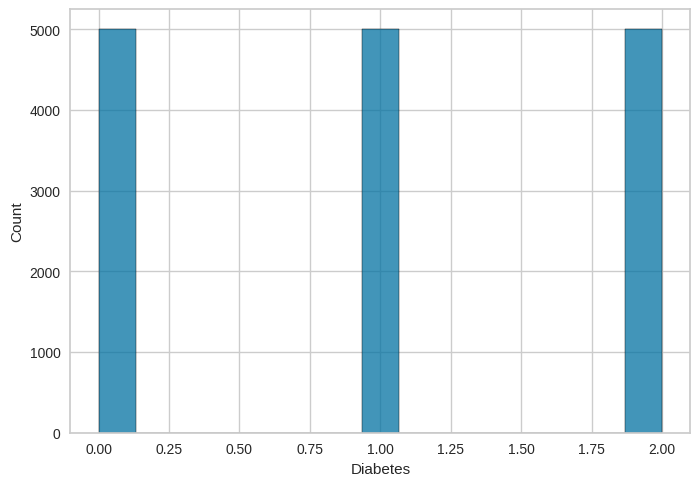

In [112]:
sns.histplot(data=X, x=y)

In [113]:
X.shape

(15000, 36)

In [114]:
df_main = pd.concat([X, y], axis=1)
df_main

Glucose_lab  Triglycerides_lab  Albumin_urine_lab  Sodium_lab  \
0       554.000000         140.000000           4.300000  136.000000   
1       219.000000         257.000000         153.000000  128.000000   
2       183.000000          51.000000          11.900000  142.000000   
3       104.000000          88.000000         255.000000  142.000000   
4       104.000000         327.000000         123.000000  143.000000   
...            ...                ...                ...         ...   
14995   170.143300         141.559420          25.577058  136.389597   
14996   203.854345         263.245724           2.786645  139.000000   
14997   148.813516         259.580411          14.173581  141.015540   
14998   240.329830         101.156524          12.885071  137.000000   
14999   131.088076         170.146794           4.699964  140.205872   

        Iron_lab  Overweight  Family_history  Gender  Age  Ethnicity  ...  \
0      58.000000    1.000000         1.00000       1   69          4  ...   
1      79.000000    2.000000         1.00000       1   54          3  ...   
2      98.000000    2.000000         2.00000       1   72          3  ...   
3      91.000000    2.000000         2.00000       2   73          3  ...   
4      52.000000    1.000000         2.00000       1   56          1  ...   
...          ...         ...             ...     ...  ...        ...  ...   
14995  76.116776    1.389597         1.00000       1   70          4  ...   
14996  75.476496    1.517450         1.00000       2   55          3  ...   
14997  94.300685    1.000000         1.01554       2   55          2  ...   
14998  81.885235    1.209471         1.00000       1   66          1  ...   
14999  81.852485    1.205872         2.00000       1   41          3  ...   

       Diet_Caffiene  Diet_Iron  Diet_Sodium  Annual_Income   Sedentary  \
0         203.000000   8.410000  1323.000000       4.000000  600.000000   
1         240.000000  26.880000  9726.000000       7.000000  540.000000   
2          45.000000  17.570000  2943.000000      10.000000  300.000000   
3          24.000000  17.720000   797.000000      15.000000  480.000000   
4         144.000000   9.520000  2651.000000       9.000000  360.000000   
...              ...        ...          ...            ...         ...   
14995     233.313123  16.718309  2266.283502       9.610403  480.000000   
14996       7.139601  10.803814  1212.778491       9.209402  151.047008   
14997     202.041919   5.282891  1143.916879       8.891218  125.594518   
14998     218.186133   6.454084  2490.360400       2.000000  167.431768   
14999     223.912645  17.290996  3826.708216      14.205872  684.704610   

       RBC_Count      BP_Sys     BP_Dia  TC_LR_1Molar  Diabetes  
0       5.090000  114.000000  76.000000        4.0000       2.0  
1       3.840000  160.000000  80.000000        4.0000       2.0  
2       5.530000  140.000000  76.000000        2.0000       2.0  
3       4.720000  134.000000  88.000000        4.0000       0.0  
4       4.930000  158.000000  82.000000        4.0000       0.0  
...          ...         ...        ...           ...       ...  
14995   4.581560  113.454358  31.167758        4.0000       2.0  
14996   4.670880  119.790598  69.860399        2.9651       2.0  
14997   4.836325  123.782435  75.813516        4.0000       2.0  
14998   4.603098  132.324236  58.837882        4.0000       2.0  
14999   4.945009  128.529178  39.705691        2.0000       2.0  

[15000 rows x 37 columns]

## 9. Save the Checkpoint File

In [115]:
df_main.to_csv("Checkpoint_1.csv", index=False)
!cp Checkpoint_1.csv /content/drive/MyDrive/Checkpoint_1.csv

In [116]:
df_main = pd.read_csv("Checkpoint_1.csv")

## 10. Data Correlation

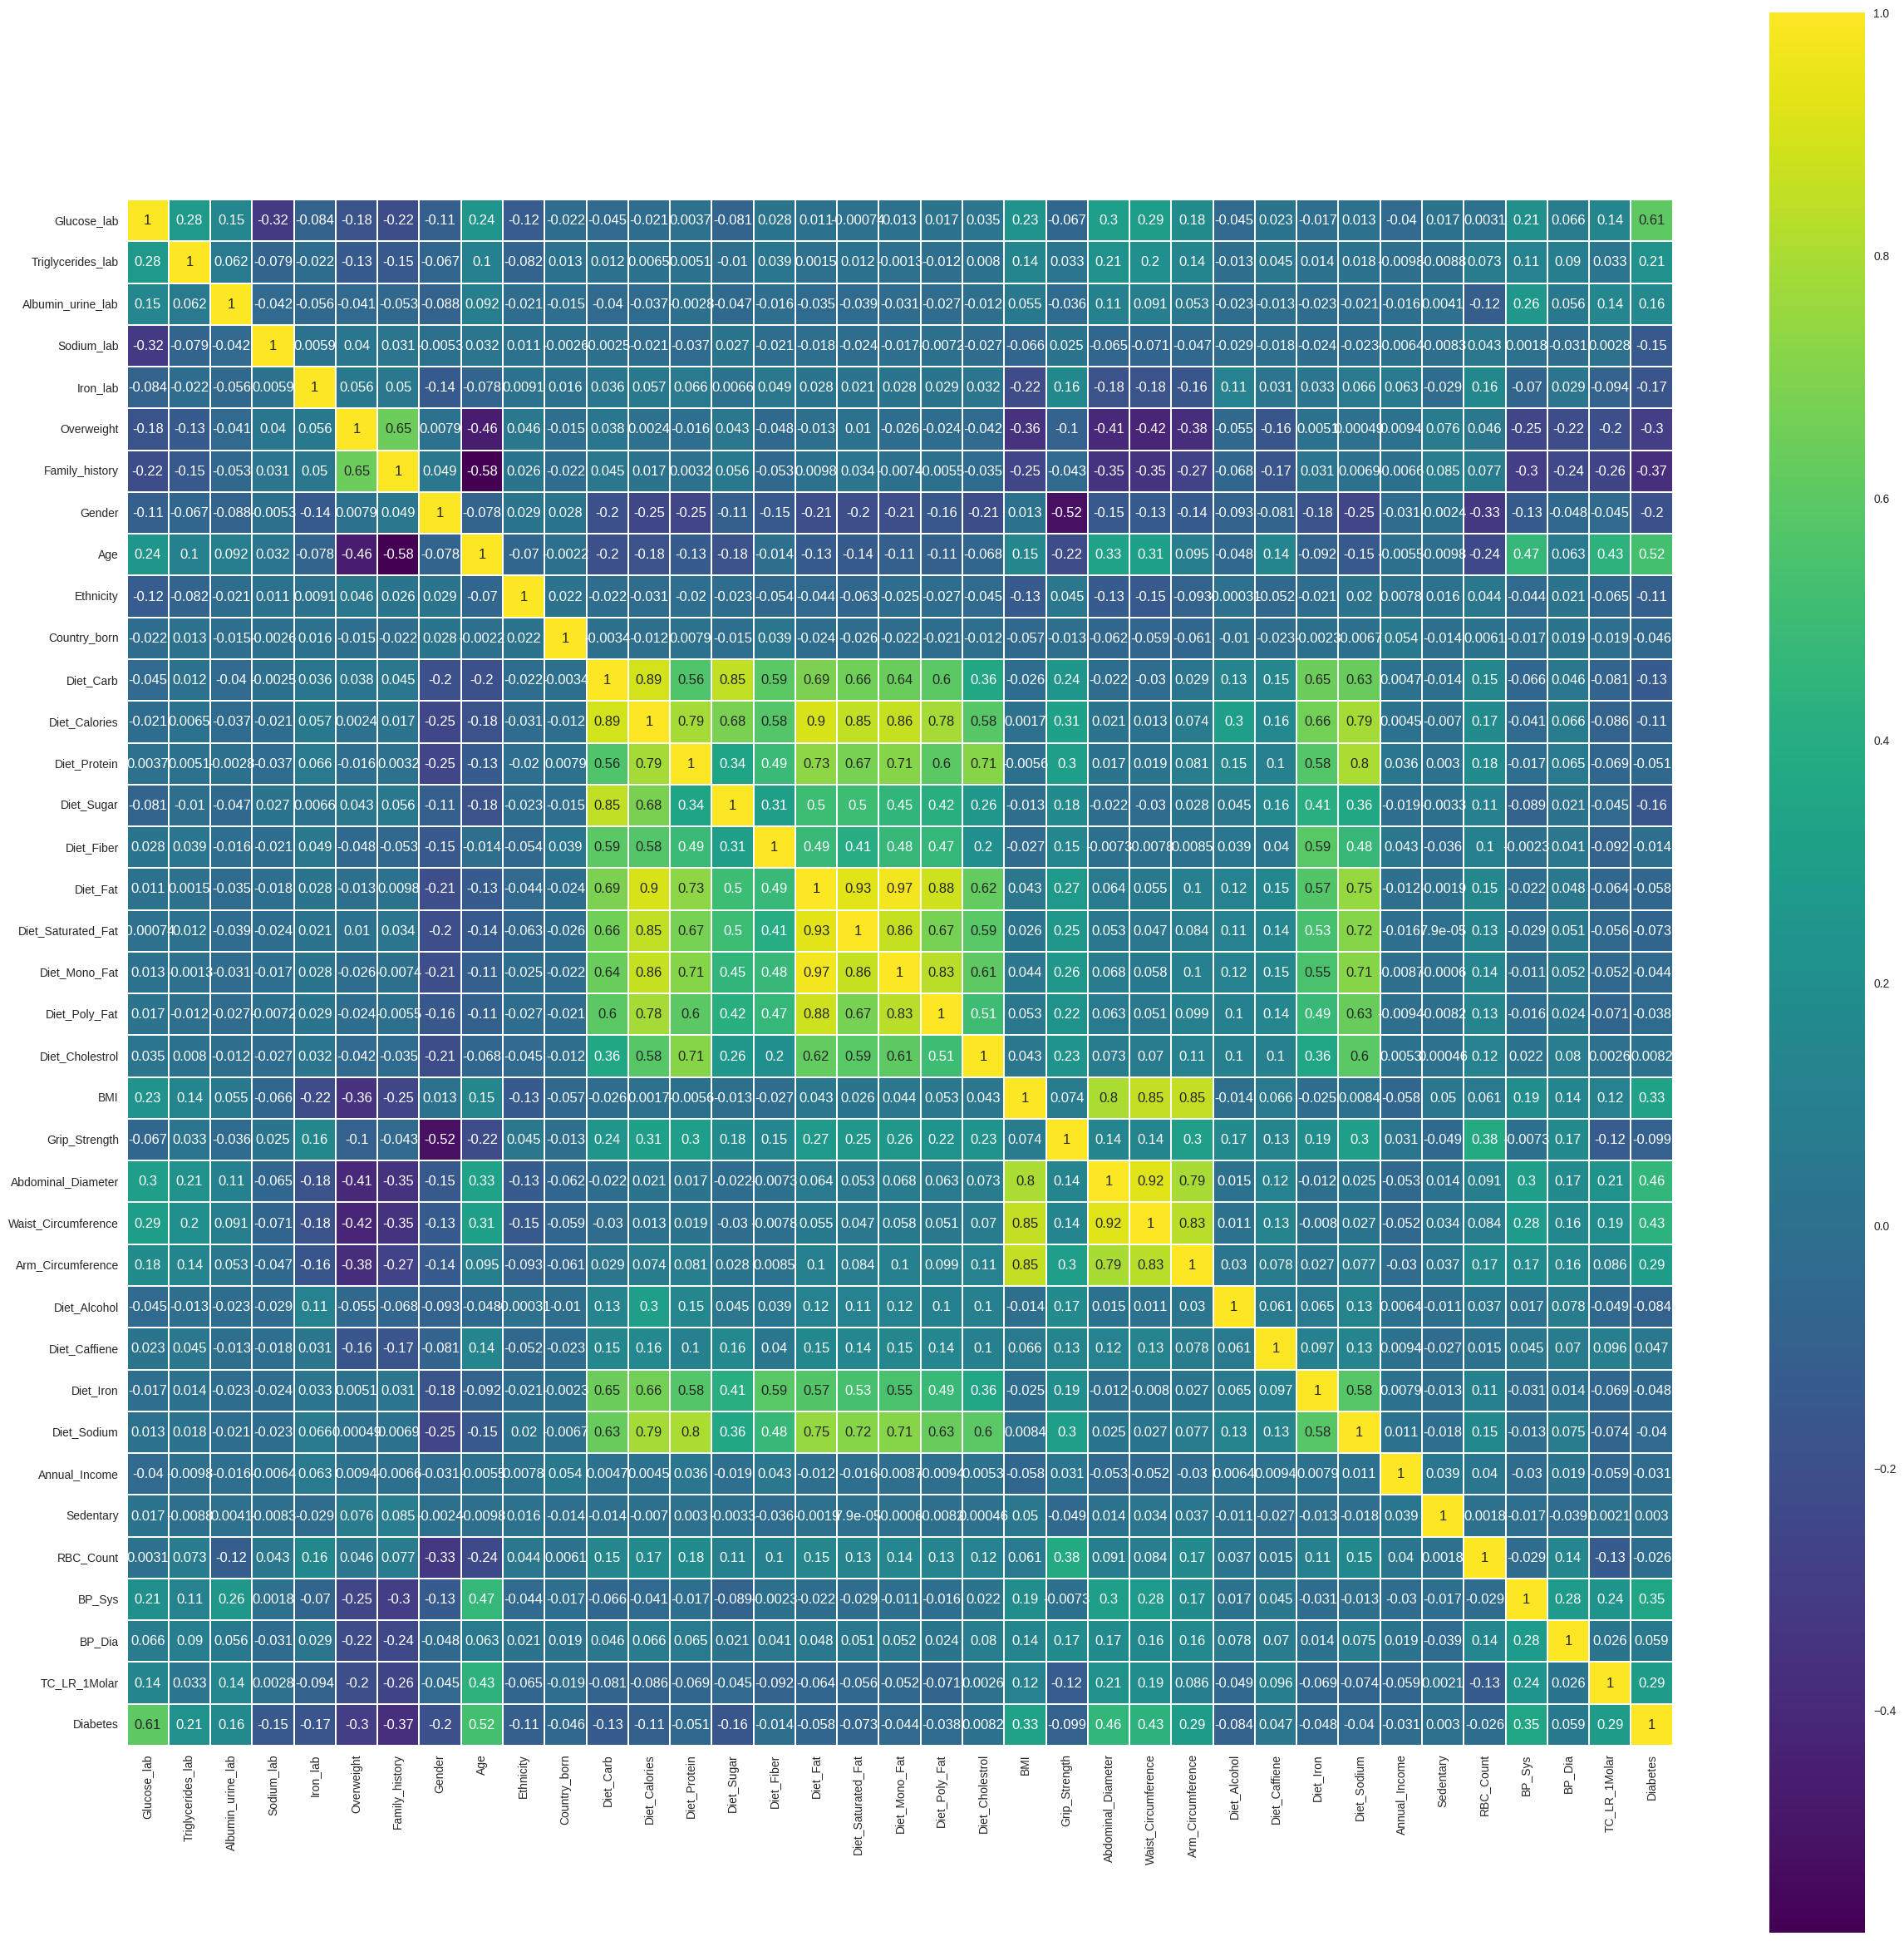

In [117]:
viz.plot_heatmap(df_main)

# Data Preparation:

## 1. Seperate the X and Y variables

In [118]:
x = df_main.drop(['Diabetes'], axis=1)
y = df_main['Diabetes']

## 2. Split the data into test-train 

## 3. Normalize the data (use MinMax because ANOVA/Chi-Squared cannot accept negative values)

In [119]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1,stratify=y)
X_train, X_test = func.minmaxscaling(X_train, X_test)
X_train = pd.DataFrame(X_train, columns = x.columns)
X_test = pd.DataFrame(X_test, columns=x.columns)


# Feature Selection 

## Feature Selection Algorithms Used

1. CatBoostClassifier
2. XGBClassifier 
3. RandomForestClassifier
4. ExtraTreesClassifier
5. LogisticRegression
6. DecisionTreeClassifier_RFE
7. chi-squared
8. ANOVA
   



## Feature Selection Methods


 The most important 20 features for CatBoostClassifier: 

1 - Glucose_lab :  16.024656663938256
2 - Age :  7.442540991979137
3 - Family_history :  4.115282737502487
4 - Albumin_urine_lab :  3.928255863682795
5 - Overweight :  3.5502095495762593
6 - Sodium_lab :  3.4213852839372136
7 - TC_LR_1Molar :  3.2738742847109465
8 - Triglycerides_lab :  3.0862839642616504
9 - BP_Sys :  2.9763266879251935
10 - RBC_Count :  2.9761494415699437
11 - BP_Dia :  2.9091310625119022
12 - Iron_lab :  2.8980042806355844
13 - Diet_Sodium :  2.8620451279869488
14 - Abdominal_Diameter :  2.709972742050202
15 - Diet_Caffiene :  2.6889898865177946
16 - Sedentary :  2.575744886128871
17 - Grip_Strength :  2.5675031525960463
18 - Diet_Iron :  2.39996931800104
19 - Diet_Sugar :  2.3850314833595965
20 - Ethnicity :  2.327110846724483

Plotting the Feature Importance Graph for the CatBoostClassifier :



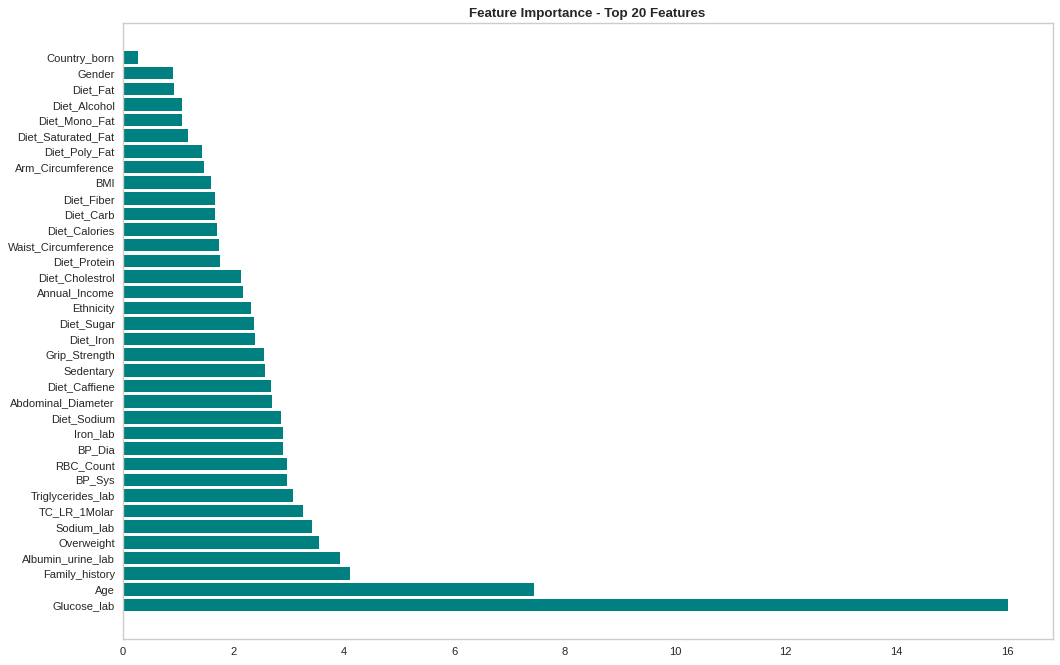


 The most important 20 features for XGBClassifier: 

1 - Glucose_lab :  0.2113062
2 - Age :  0.117342666
3 - Overweight :  0.057500582
4 - TC_LR_1Molar :  0.056284253
5 - Family_history :  0.0518823
6 - Gender :  0.027703201
7 - Abdominal_Diameter :  0.027072024
8 - Diet_Alcohol :  0.023857825
9 - Albumin_urine_lab :  0.022178436
10 - Ethnicity :  0.02165726
11 - BP_Sys :  0.018635608
12 - Iron_lab :  0.01828002
13 - BP_Dia :  0.018197464
14 - Diet_Sugar :  0.016767263
15 - Sodium_lab :  0.016518677
16 - Diet_Caffiene :  0.016026996
17 - Diet_Fat :  0.016012399
18 - Arm_Circumference :  0.015539186
19 - Annual_Income :  0.015362966
20 - Waist_Circumference :  0.015204742

Plotting the Feature Importance Graph for the XGBClassifier :



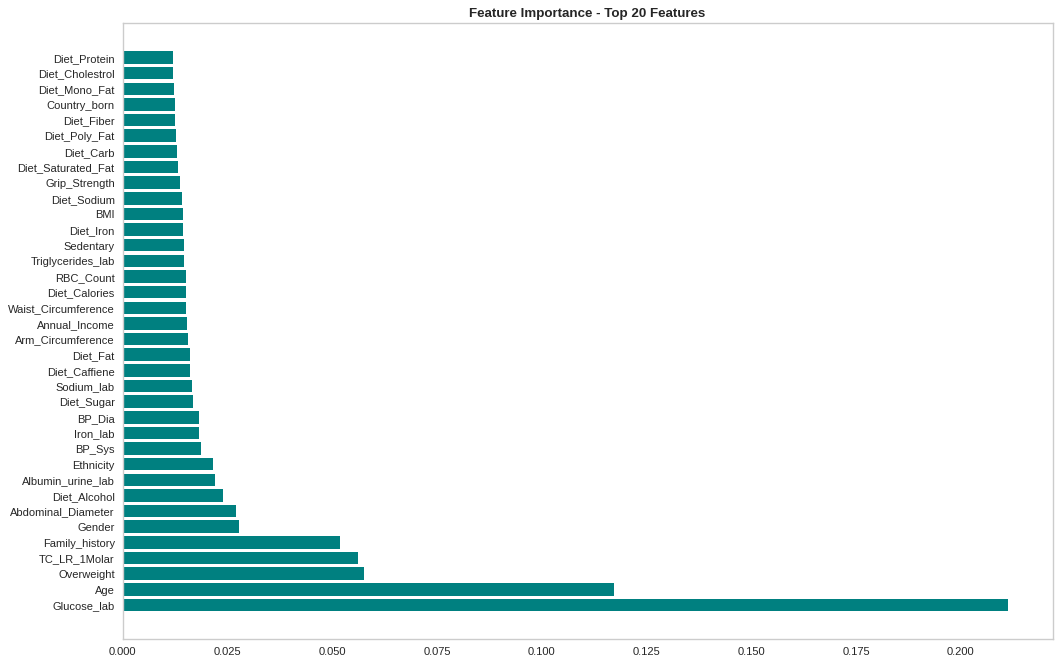


 The most important 20 features for RandomForestClassifier: 

1 - Glucose_lab :  0.23733118848193133
2 - Age :  0.08734538412565487
3 - Family_history :  0.044953883302298006
4 - Abdominal_Diameter :  0.03754854873444998
5 - Albumin_urine_lab :  0.03649108515070609
6 - Waist_Circumference :  0.036438786415968726
7 - TC_LR_1Molar :  0.036227108779866034
8 - BP_Sys :  0.034053358158670194
9 - Sodium_lab :  0.027505602185350926
10 - Overweight :  0.02695619160932258
11 - BMI :  0.0254366311060531
12 - Triglycerides_lab :  0.023265838989150814
13 - Iron_lab :  0.02053215281662823
14 - RBC_Count :  0.019371479590116068
15 - Arm_Circumference :  0.018770245645462837
16 - Grip_Strength :  0.01859044324866676
17 - BP_Dia :  0.01839379981599147
18 - Diet_Sugar :  0.017933568612552124
19 - Diet_Caffiene :  0.017908658615606105
20 - Annual_Income :  0.016751193841690135

Plotting the Feature Importance Graph for the RandomForestClassifier :



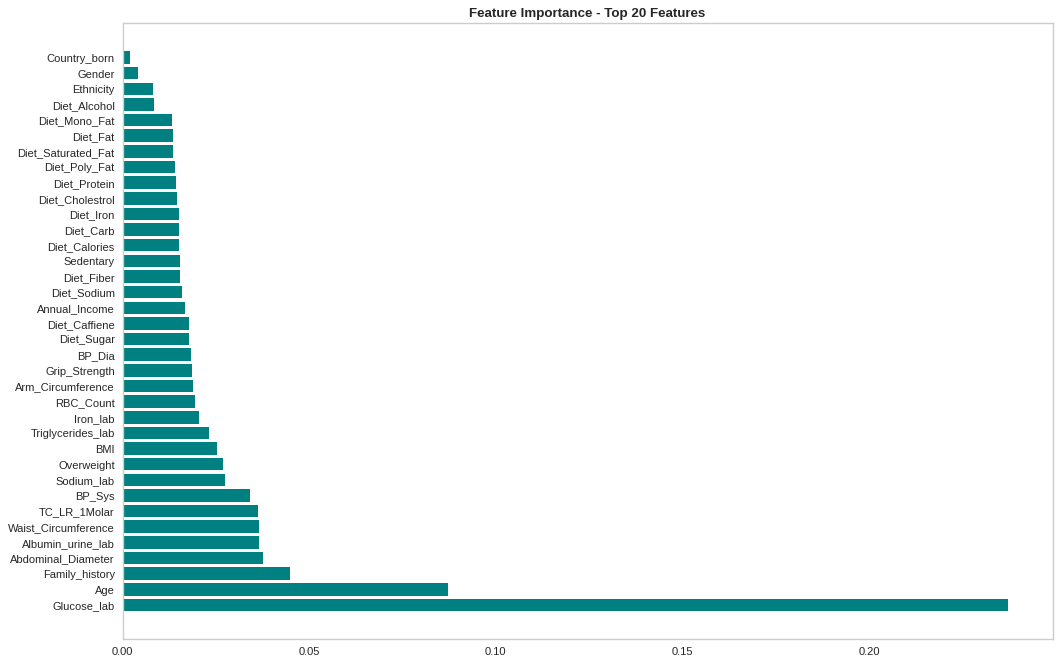


 The most important 20 features for ExtraTreesClassifier: 

1 - Glucose_lab :  0.1502014482909677
2 - Age :  0.09272388472690948
3 - Family_history :  0.05305117208362291
4 - Abdominal_Diameter :  0.04032326425460335
5 - TC_LR_1Molar :  0.037986582852805956
6 - Waist_Circumference :  0.03644718141441668
7 - Overweight :  0.0309310642985174
8 - BP_Sys :  0.02790945458351239
9 - Albumin_urine_lab :  0.0272712121831578
10 - BMI :  0.026094568166636068
11 - Sodium_lab :  0.02527439584091701
12 - Grip_Strength :  0.023228372279742317
13 - Arm_Circumference :  0.02267665750352359
14 - Iron_lab :  0.021655665644560795
15 - Diet_Sugar :  0.020551696439358474
16 - Triglycerides_lab :  0.020374719111868764
17 - Ethnicity :  0.019784961246696743
18 - RBC_Count :  0.01946365136949524
19 - Sedentary :  0.019412038656073303
20 - BP_Dia :  0.01901686345727945

Plotting the Feature Importance Graph for the ExtraTreesClassifier :



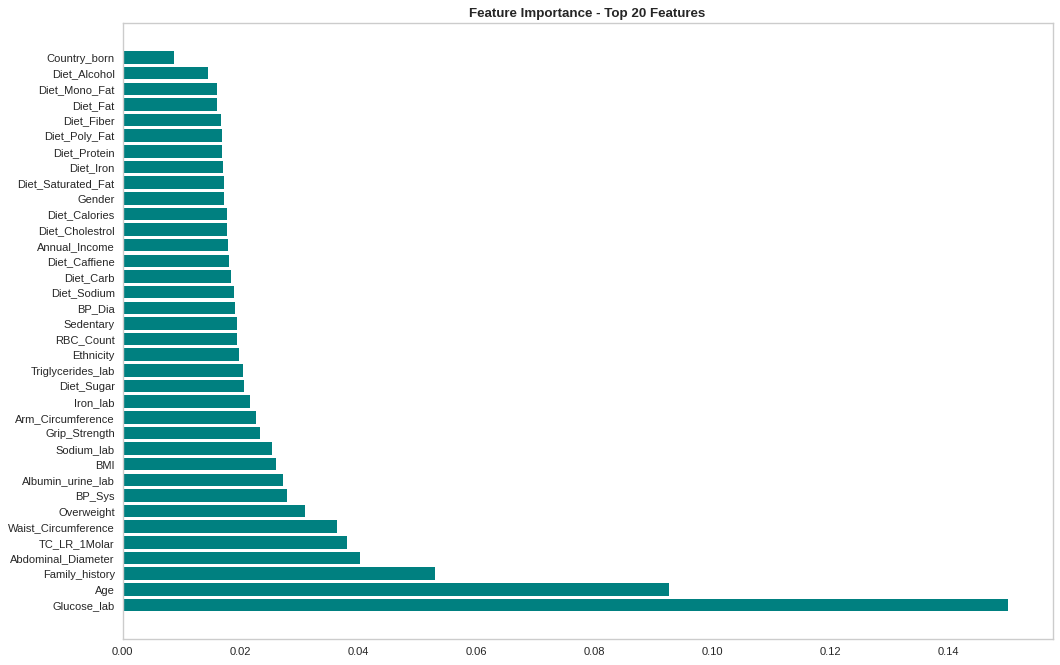


 The most important 20 features for LogisticRegression: 

1 - Glucose_lab :  12.098949305077559
2 - Iron_lab :  3.789153304046561
3 - Age :  2.8051011759158095
4 - Abdominal_Diameter :  2.5286849965436393
5 - Grip_Strength :  2.016697220847211
6 - Diet_Alcohol :  1.7436445832117697
7 - BMI :  1.7006029632009112
8 - RBC_Count :  1.5450775367510359
9 - Diet_Caffiene :  1.2733982165769309
10 - Diet_Sodium :  1.2628416817192765
11 - Sodium_lab :  1.1394494003249664
12 - Waist_Circumference :  1.1329699503240773
13 - Country_born :  1.062648587003103
14 - Arm_Circumference :  0.9940816534917747
15 - Diet_Calories :  0.9655071221286866
16 - Diet_Sugar :  0.8989251473399678
17 - Albumin_urine_lab :  0.8914827763939404
18 - Diet_Cholestrol :  0.8512490784500261
19 - Gender :  0.8484490220833646
20 - Family_history :  0.7774201666056912

Plotting the Feature Importance Graph for the LogisticRegression :



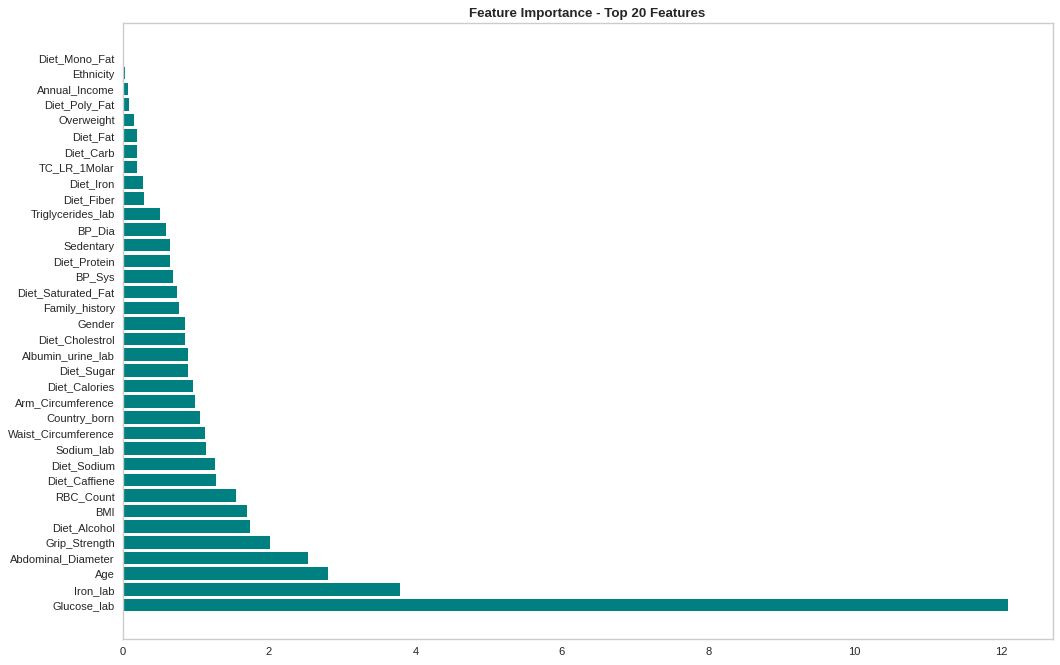


 The most important 20 features for DecisionTreeClassifier_RFE: 

1 - Glucose_lab :  0.3517647642130816
2 - Family_history :  0.13908338730443306
3 - Albumin_urine_lab :  0.043612250033795166
4 - Diet_Calories :  0.03987629986060621
5 - Diet_Poly_Fat :  0.03664640944654225
6 - Iron_lab :  0.034772082844665424
7 - Country_born :  0.028792909937805568
8 - Triglycerides_lab :  0.0282174780030702
9 - Diet_Fiber :  0.02815695580702431
10 - Diet_Sugar :  0.027968443416291636
11 - Ethnicity :  0.027508482182862847
12 - Diet_Carb :  0.027038611612821617
13 - Overweight :  0.025402794865707252
14 - Gender :  0.02535418521643984
15 - Age :  0.02510821849213951
16 - Diet_Mono_Fat :  0.024153584556467333
17 - Sodium_lab :  0.02353179685847588
18 - Diet_Protein :  0.021747235936859448
19 - Diet_Saturated_Fat :  0.021060578141426936
20 - Diet_Fat :  0.020203531269483856

Plotting the Feature Importance Graph for the DecisionTreeClassifier_RFE :



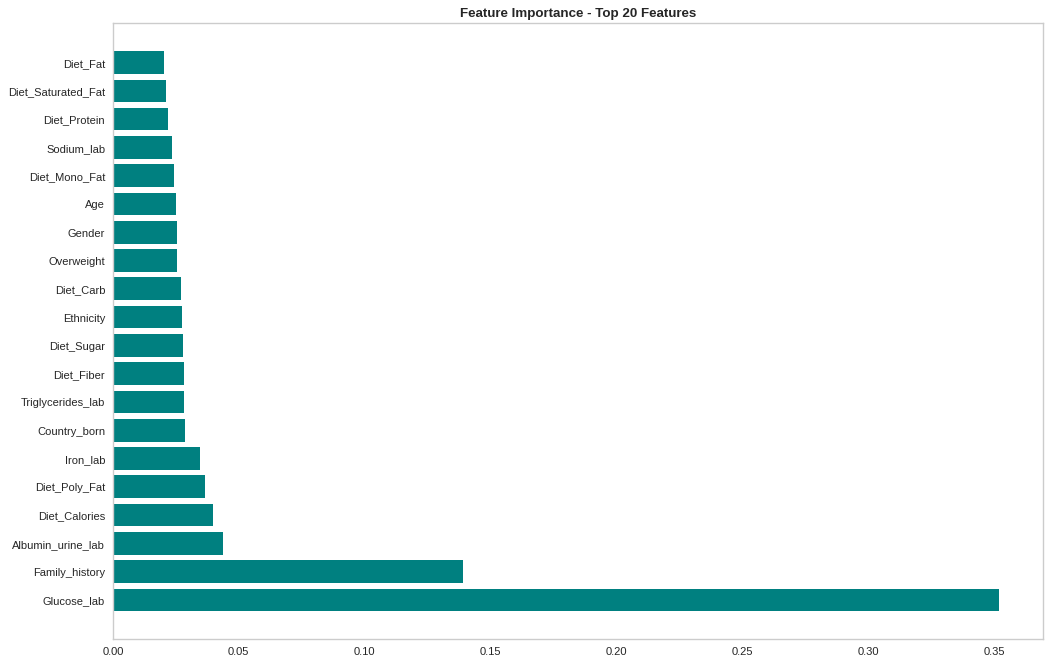


 The most important 20 features for chi-squared: 

1 - Family_history :  820.1852709961368
2 - Age :  446.2795758673743
3 - Overweight :  371.4716800059625
4 - Glucose_lab :  362.814305487531
5 - TC_LR_1Molar :  333.9739405374321
6 - Gender :  268.8047070605973
7 - Abdominal_Diameter :  138.73907825227877
8 - Waist_Circumference :  109.67267033986353
9 - Albumin_urine_lab :  93.67086427828022
10 - BMI :  51.638624879945766
11 - BP_Sys :  43.8617181247437
12 - Arm_Circumference :  35.922653473880516
13 - Ethnicity :  19.31147162137069
14 - Triglycerides_lab :  17.217637925397526
15 - Diet_Sugar :  10.712133786394272
16 - Diet_Alcohol :  9.913699224207717
17 - Iron_lab :  7.959459998406055
18 - Diet_Carb :  7.067958835566133
19 - Diet_Calories :  5.127377813840801
20 - Annual_Income :  4.967119410470598

Plotting the Feature Importance Graph for the chi-squared :



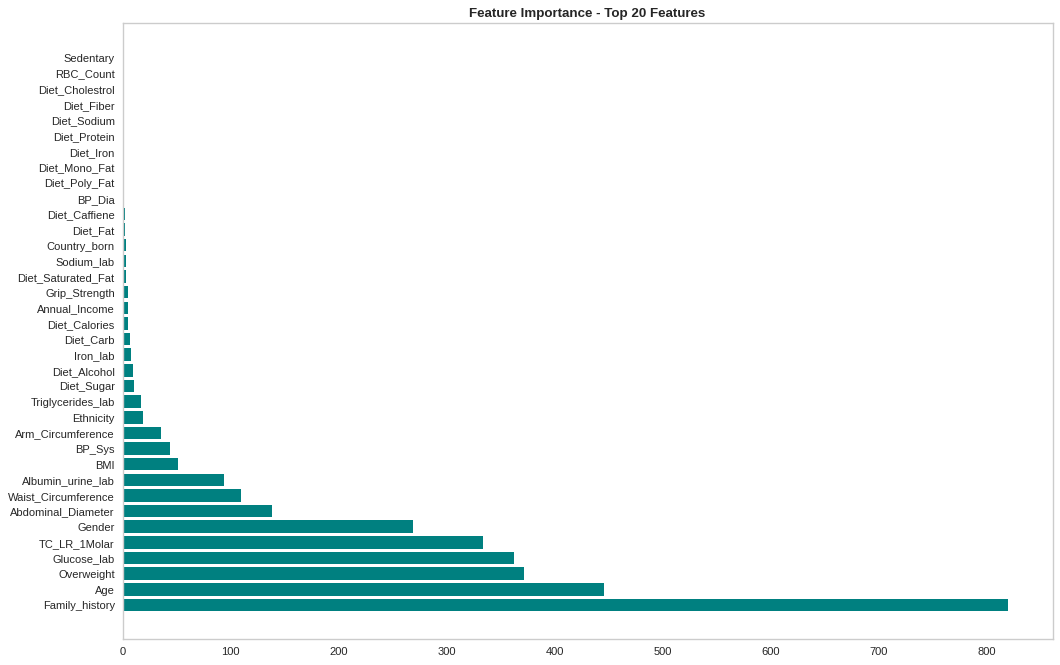


 The most important 20 features for anova: 

1 - Glucose_lab :  4032.979392600912
2 - Age :  2476.018772766939
3 - Abdominal_Diameter :  1489.6771589838852
4 - Waist_Circumference :  1267.7537202614105
5 - Family_history :  963.2430159009663
6 - BP_Sys :  796.9893705942227
7 - BMI :  687.9094881569875
8 - Overweight :  558.167164930846
9 - Arm_Circumference :  517.6927732930616
10 - TC_LR_1Molar :  513.4326837500553
11 - Sodium_lab :  264.8173471391202
12 - Triglycerides_lab :  258.6521859075526
13 - Gender :  226.1948582249105
14 - Albumin_urine_lab :  208.21669417159046
15 - Iron_lab :  176.60065787705696
16 - Diet_Sugar :  138.6971015821803
17 - Diet_Carb :  93.37485133424755
18 - Diet_Calories :  65.56300720018035
19 - Ethnicity :  63.02512080770105
20 - Grip_Strength :  48.83253158729188

Plotting the Feature Importance Graph for the anova :



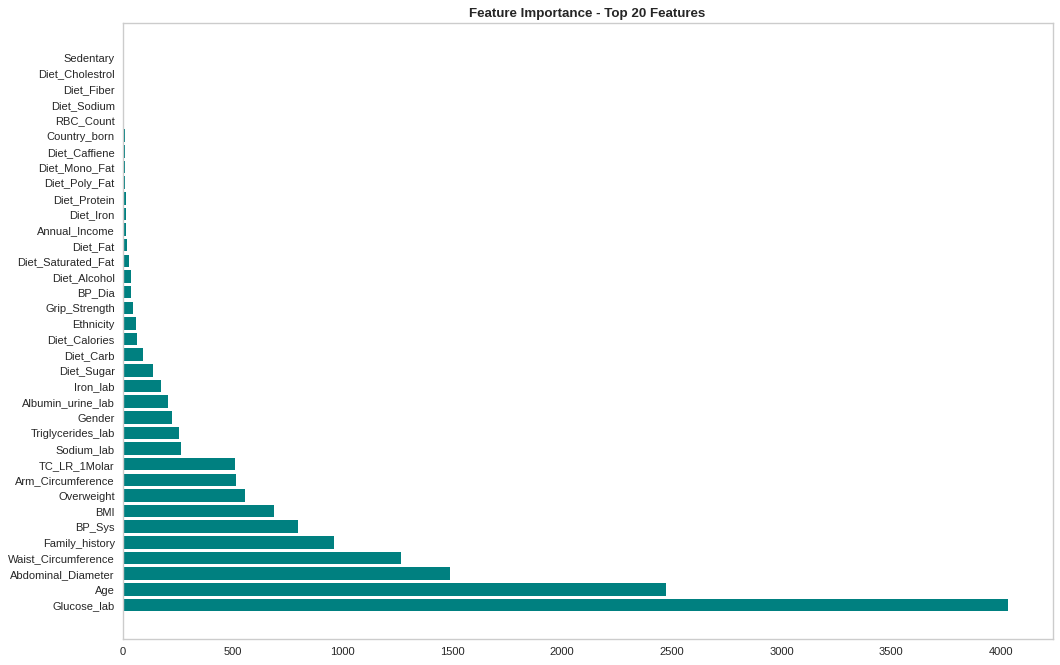

Top 10 features for each model:

CatBoostClassifier = ['Glucose_lab', 'Age', 'Family_history', 'Albumin_urine_lab', 'Overweight', 'Sodium_lab', 'TC_LR_1Molar', 'Triglycerides_lab', 'BP_Sys', 'RBC_Count']

XGBClassifier = ['Glucose_lab', 'Age', 'Overweight', 'TC_LR_1Molar', 'Family_history', 'Gender', 'Abdominal_Diameter', 'Diet_Alcohol', 'Albumin_urine_lab', 'Ethnicity']

RandomForestClassifier = ['Glucose_lab', 'Age', 'Family_history', 'Abdominal_Diameter', 'Albumin_urine_lab', 'Waist_Circumference', 'TC_LR_1Molar', 'BP_Sys', 'Sodium_lab', 'Overweight']

ExtraTreesClassifier = ['Glucose_lab', 'Age', 'Family_history', 'Abdominal_Diameter', 'TC_LR_1Molar', 'Waist_Circumference', 'Overweight', 'BP_Sys', 'Albumin_urine_lab', 'BMI']

LogisticRegression = ['Glucose_lab', 'Iron_lab', 'Age', 'Abdominal_Diameter', 'Grip_Strength', 'Diet_Alcohol', 'BMI', 'RBC_Count', 'Diet_Caffiene', 'Diet_Sodium']

DecisionTreeClassifier_RFE = ['Glucose_lab', 'Family_history', 'Albumin_urine_lab', 'Diet_Calori

In [126]:
from sklearn.linear_model import LogisticRegression
models = ['CatBoostClassifier', 'XGBClassifier', 'RandomForestClassifier', 'ExtraTreesClassifier', 
          'LogisticRegression','DecisionTreeClassifier_RFE','chi-squared','anova']

feature_list = []

for model_name in models:
    # Train the model
    model = feature_imp.train_model(model_name, X_train, y_train)
    # Get the top 5 features
    Top20_features = feature_imp.feature_imp(model_name, model, X_train)
    top10_features = Top20_features[:10]
    
    feature_list.append(top10_features)
    
print("Top 10 features for each model:\n")
for i, model_name in enumerate(models):
    print(f"{model_name} = {feature_list[i]}\n")


# Data Modeling

## Random Forest Classifier

In [122]:
seed = 2023
def train_model_without_FE(model_name, X_train, y_train, X_test, y_test):
  print("********************************************* WITHOUT FEATURE SELECTION **********************************************")
  cls_model_obj.model_training(model_name, X_train, y_train, X_test, y_test)
   

In [123]:
def train_model_with_FE(model_name, X_train, y_train, X_test, y_test):
  print("********************************************* WITH FEATURE SELECTION **********************************************")
  fet_models = ['CatBoostClassifier', 'XGBClassifier', 'RandomForestClassifier', 'ExtraTreesClassifier', 'LogisticRegression','DecisionTreeClassifier_RFE','chi-squared','anova']
  for i, model_name_fet in enumerate(fet_models):
    print(f"{model_name_fet} = {feature_list[i]}\n")
    X_train_fet = X_train[feature_list[i]]
    X_test_fet = X_test[feature_list[i]]
    cls_model_obj.model_training_FE(model_name, X_train_fet, y_train, X_test_fet, y_test)

********************************************* WITHOUT FEATURE SELECTION **********************************************
Best Parameters:  {'ccp_alpha': 0, 'criterion': 'gini'}
Best Score:  0.860857142857143
Standard Deviation:  0.0028155705712561065
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1500
           1       0.80      0.81      0.80      1500
           2       0.93      0.94      0.94      1500

    accuracy                           0.86      4500
   macro avg       0.86      0.86      0.86      4500
weighted avg       0.86      0.86      0.86      4500



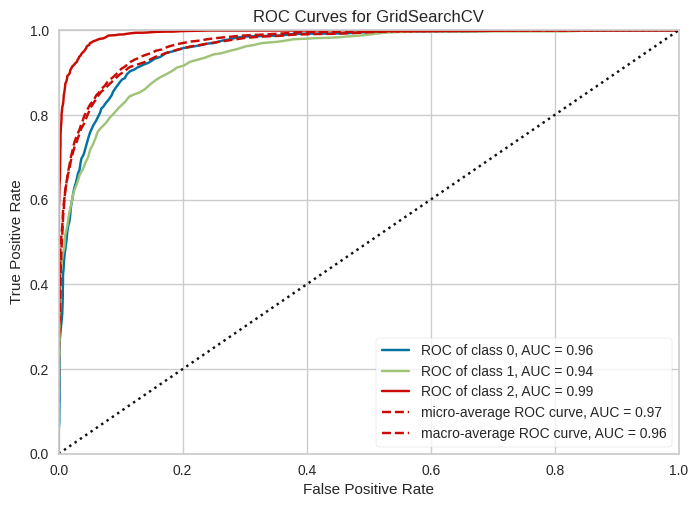

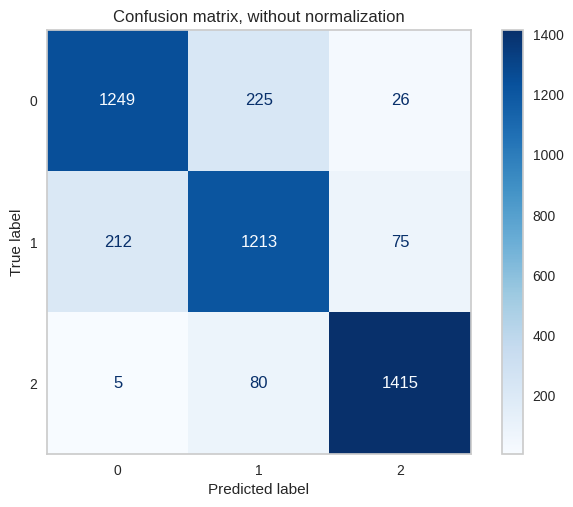

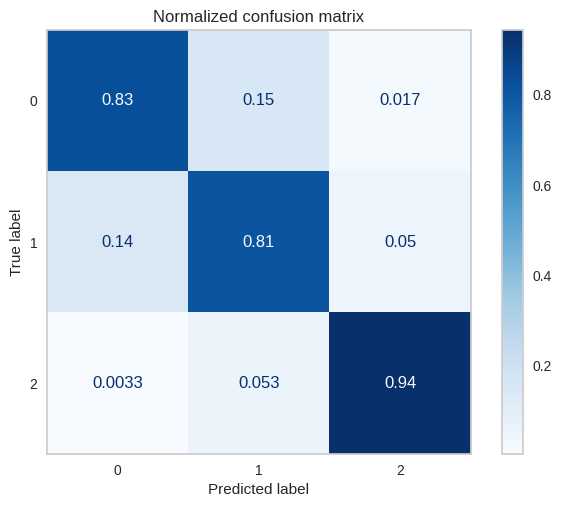

In [124]:
train_model_without_FE('RandomForestClassifier',X_train,y_train,X_test,y_test)

********************************************* WITH FEATURE SELECTION **********************************************
CatBoostClassifier = ['Glucose_lab', 'Age', 'Family_history', 'Albumin_urine_lab', 'Overweight', 'Sodium_lab', 'TC_LR_1Molar', 'Triglycerides_lab', 'BP_Sys', 'RBC_Count']

              precision    recall  f1-score   support

           0       0.83      0.81      0.82      1500
           1       0.75      0.76      0.76      1500
           2       0.90      0.90      0.90      1500

    accuracy                           0.83      4500
   macro avg       0.83      0.83      0.83      4500
weighted avg       0.83      0.83      0.83      4500



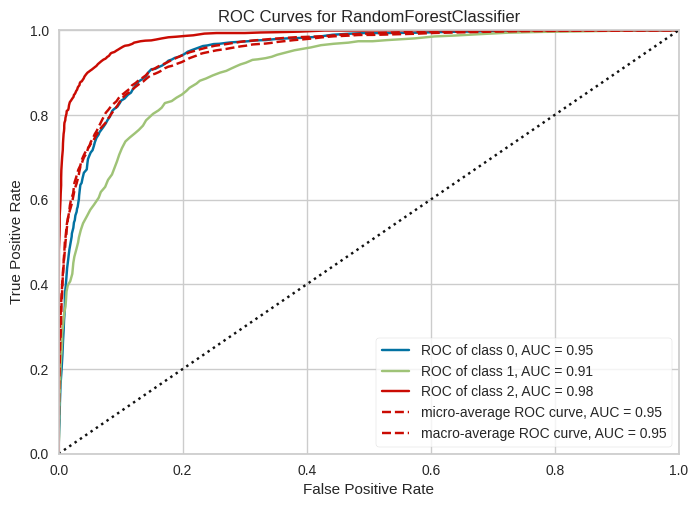

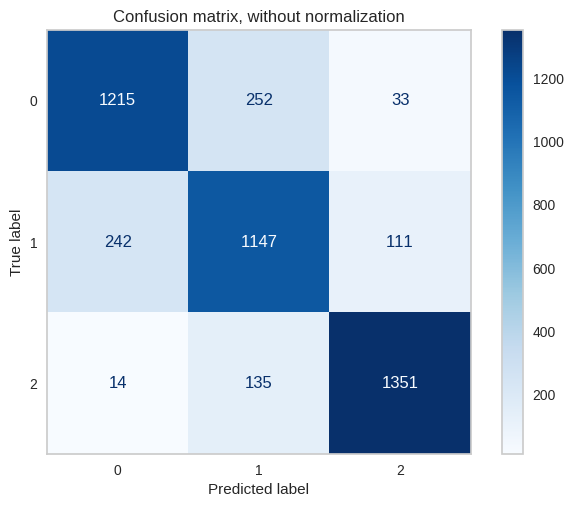

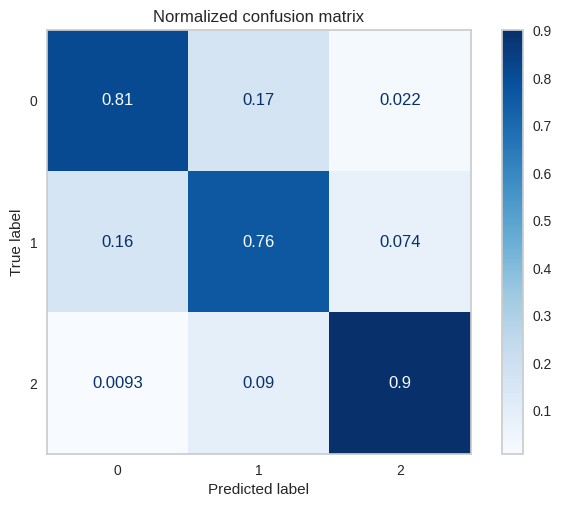

XGBClassifier = ['Glucose_lab', 'Age', 'Overweight', 'TC_LR_1Molar', 'Family_history', 'Gender', 'Abdominal_Diameter', 'Diet_Alcohol', 'Albumin_urine_lab', 'Ethnicity']

              precision    recall  f1-score   support

           0       0.82      0.83      0.82      1500
           1       0.75      0.74      0.75      1500
           2       0.90      0.89      0.89      1500

    accuracy                           0.82      4500
   macro avg       0.82      0.82      0.82      4500
weighted avg       0.82      0.82      0.82      4500



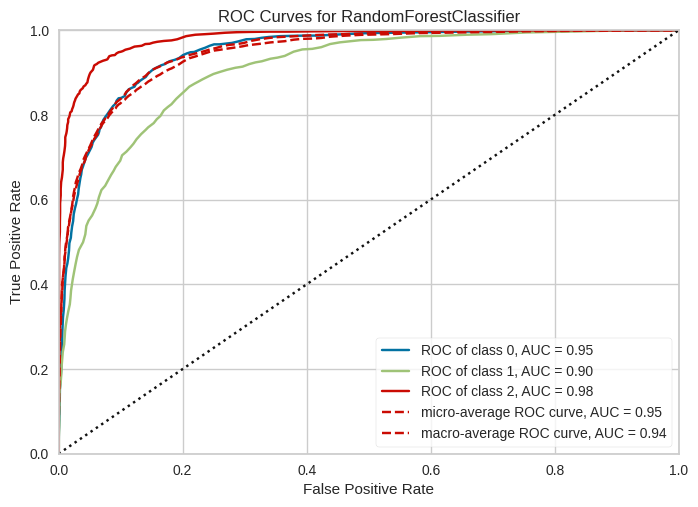

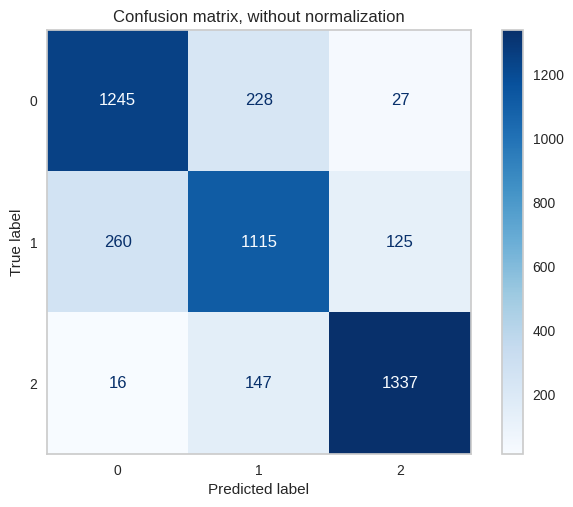

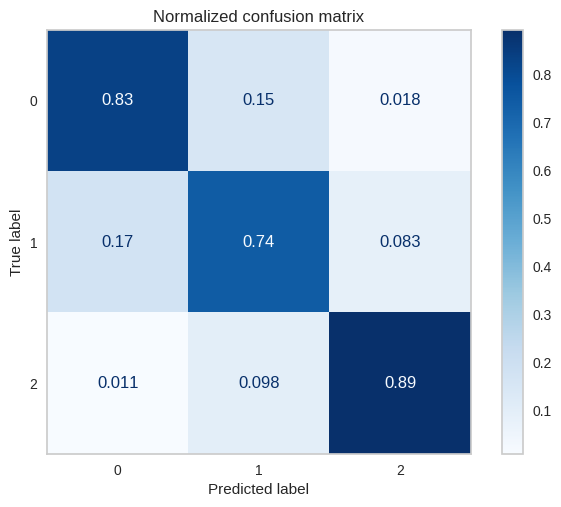

RandomForestClassifier = ['Glucose_lab', 'Age', 'Family_history', 'Abdominal_Diameter', 'Albumin_urine_lab', 'Waist_Circumference', 'TC_LR_1Molar', 'BP_Sys', 'Sodium_lab', 'Overweight']

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1500
           1       0.75      0.76      0.75      1500
           2       0.91      0.90      0.90      1500

    accuracy                           0.83      4500
   macro avg       0.83      0.83      0.83      4500
weighted avg       0.83      0.83      0.83      4500



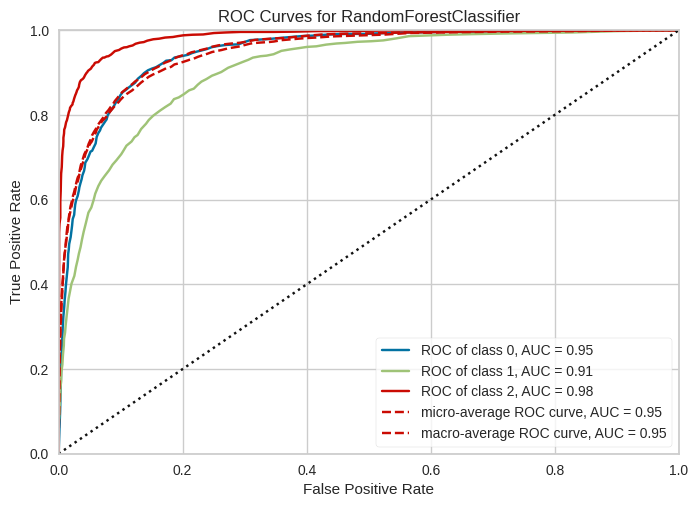

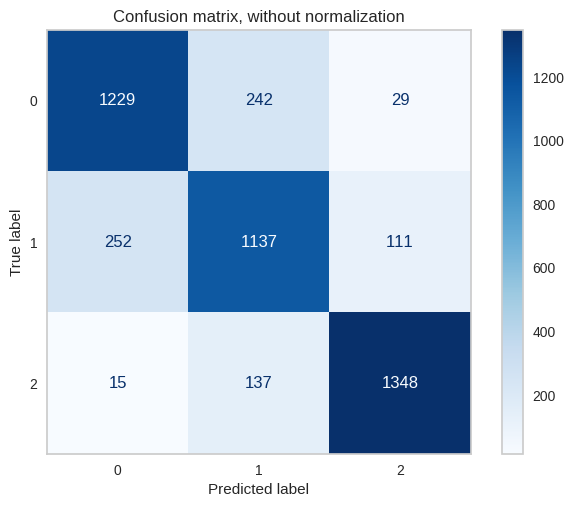

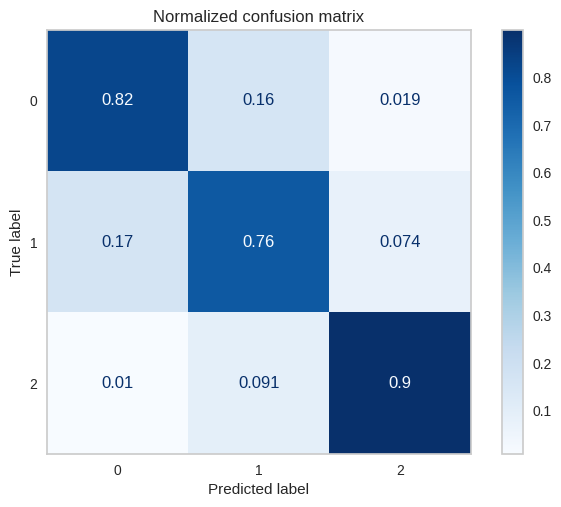

ExtraTreesClassifier = ['Glucose_lab', 'Age', 'Family_history', 'Abdominal_Diameter', 'TC_LR_1Molar', 'Waist_Circumference', 'Overweight', 'BP_Sys', 'Albumin_urine_lab', 'BMI']

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1500
           1       0.75      0.75      0.75      1500
           2       0.90      0.90      0.90      1500

    accuracy                           0.82      4500
   macro avg       0.82      0.82      0.82      4500
weighted avg       0.82      0.82      0.82      4500



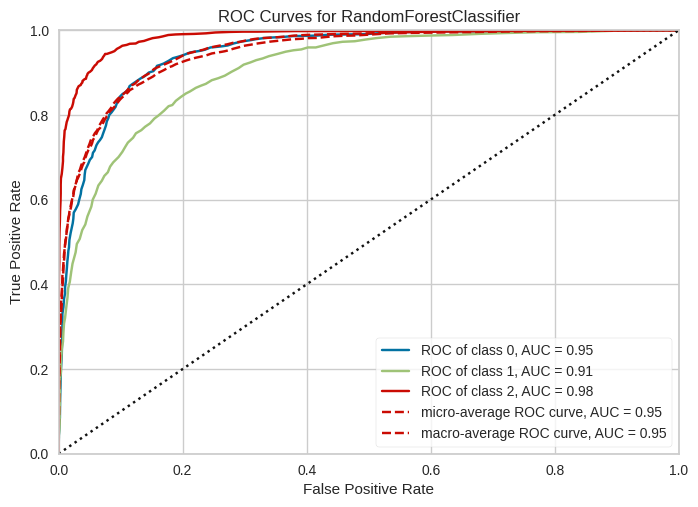

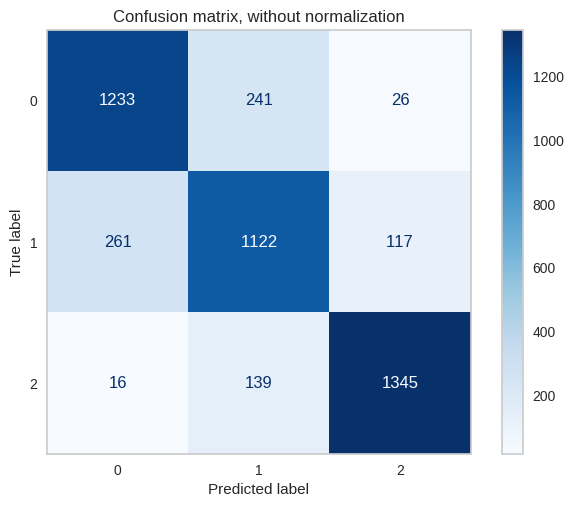

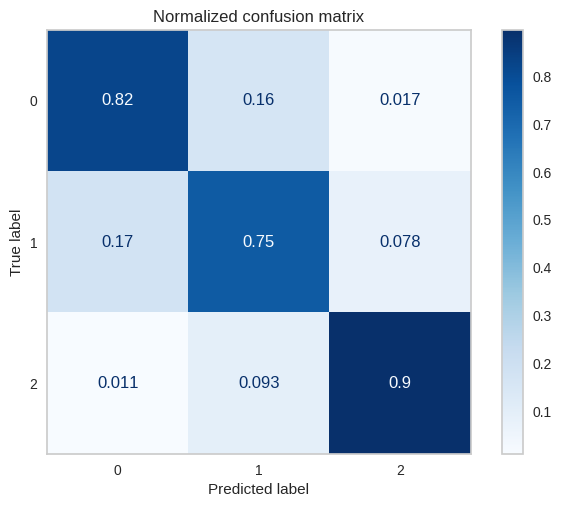

LogisticRegression = ['Glucose_lab', 'Iron_lab', 'Age', 'Abdominal_Diameter', 'Grip_Strength', 'Diet_Alcohol', 'BMI', 'RBC_Count', 'Diet_Caffiene', 'Diet_Sodium']

              precision    recall  f1-score   support

           0       0.84      0.80      0.82      1500
           1       0.76      0.79      0.77      1500
           2       0.92      0.92      0.92      1500

    accuracy                           0.84      4500
   macro avg       0.84      0.84      0.84      4500
weighted avg       0.84      0.84      0.84      4500



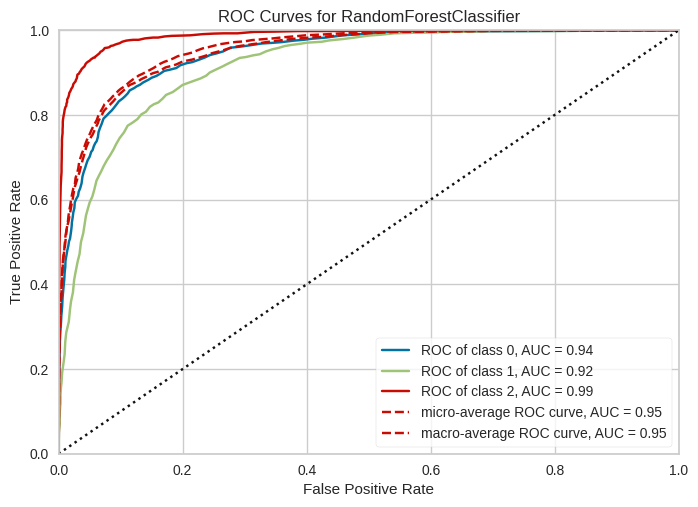

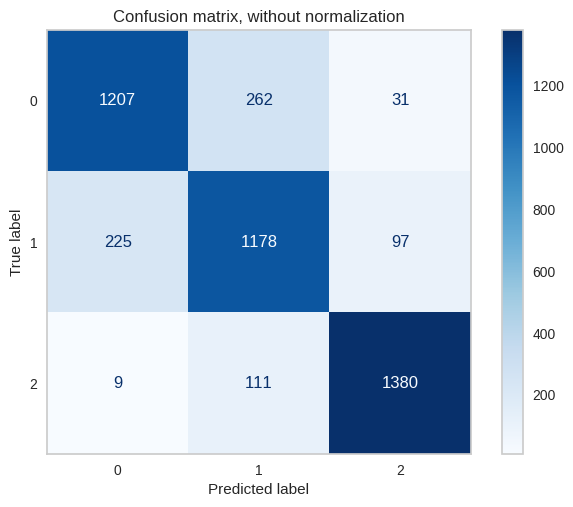

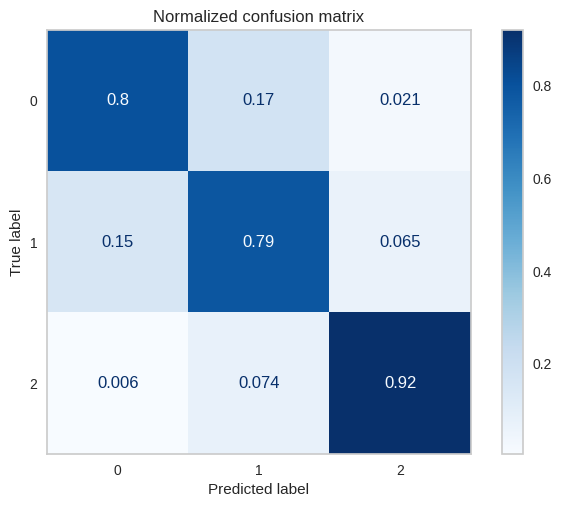

DecisionTreeClassifier_RFE = ['Glucose_lab', 'Family_history', 'Albumin_urine_lab', 'Diet_Calories', 'Diet_Poly_Fat', 'Iron_lab', 'Country_born', 'Triglycerides_lab', 'Diet_Fiber', 'Diet_Sugar']

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      1500
           1       0.75      0.76      0.75      1500
           2       0.91      0.92      0.91      1500

    accuracy                           0.82      4500
   macro avg       0.82      0.82      0.82      4500
weighted avg       0.82      0.82      0.82      4500



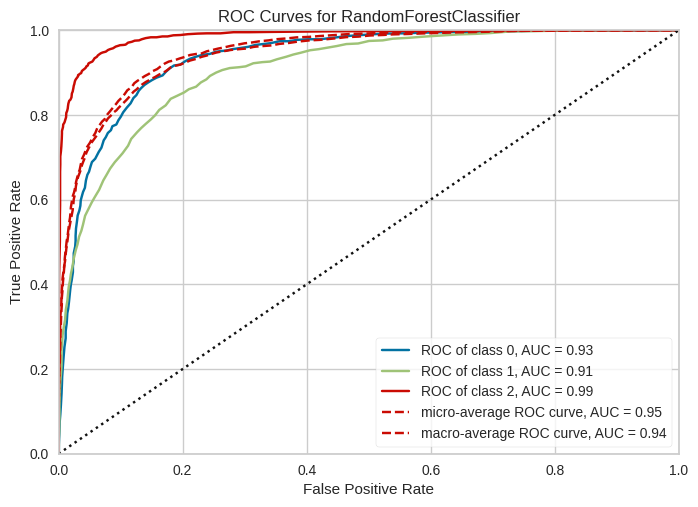

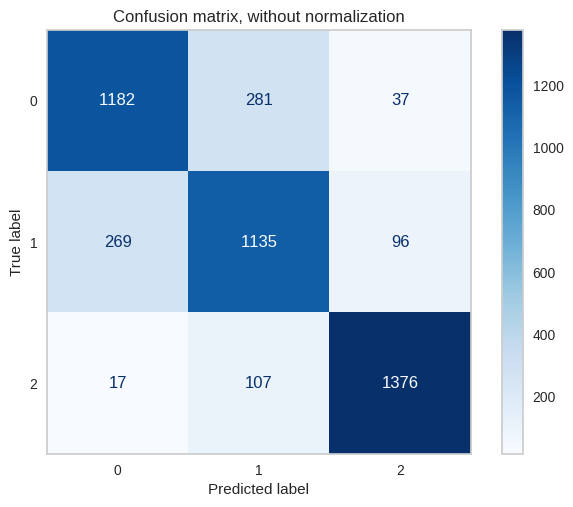

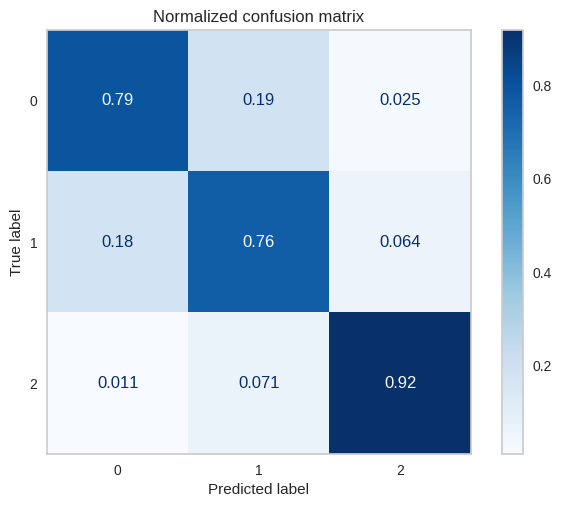

chi-squared = ['Family_history', 'Age', 'Overweight', 'Glucose_lab', 'TC_LR_1Molar', 'Gender', 'Abdominal_Diameter', 'Waist_Circumference', 'Albumin_urine_lab', 'BMI']

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1500
           1       0.74      0.75      0.74      1500
           2       0.90      0.89      0.89      1500

    accuracy                           0.82      4500
   macro avg       0.82      0.82      0.82      4500
weighted avg       0.82      0.82      0.82      4500



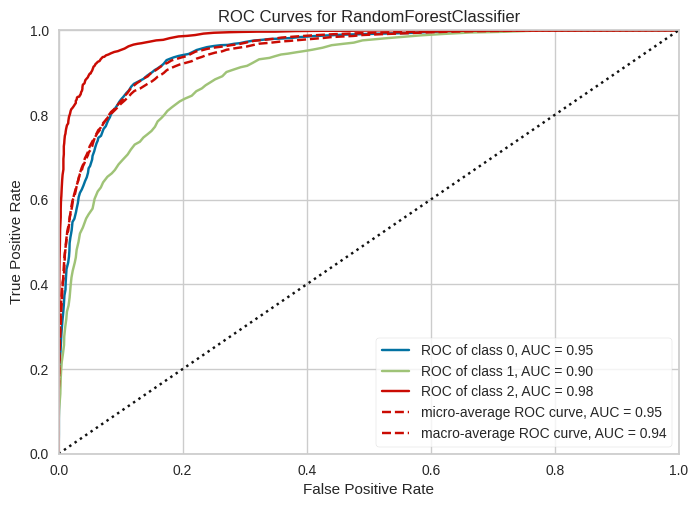

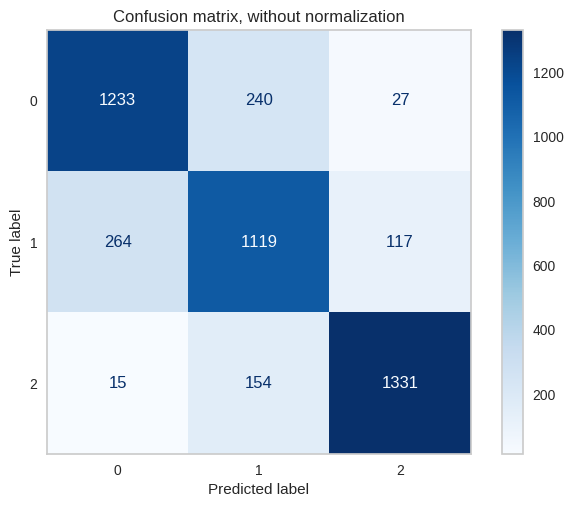

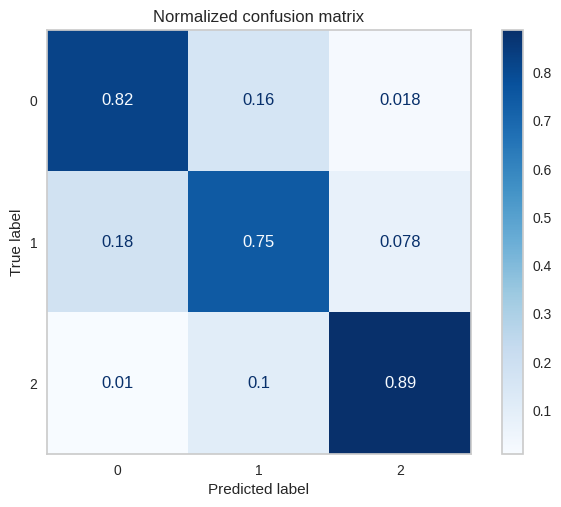

anova = ['Glucose_lab', 'Age', 'Abdominal_Diameter', 'Waist_Circumference', 'Family_history', 'BP_Sys', 'BMI', 'Overweight', 'Arm_Circumference', 'TC_LR_1Molar']

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1500
           1       0.75      0.76      0.75      1500
           2       0.90      0.89      0.90      1500

    accuracy                           0.82      4500
   macro avg       0.82      0.82      0.82      4500
weighted avg       0.82      0.82      0.82      4500



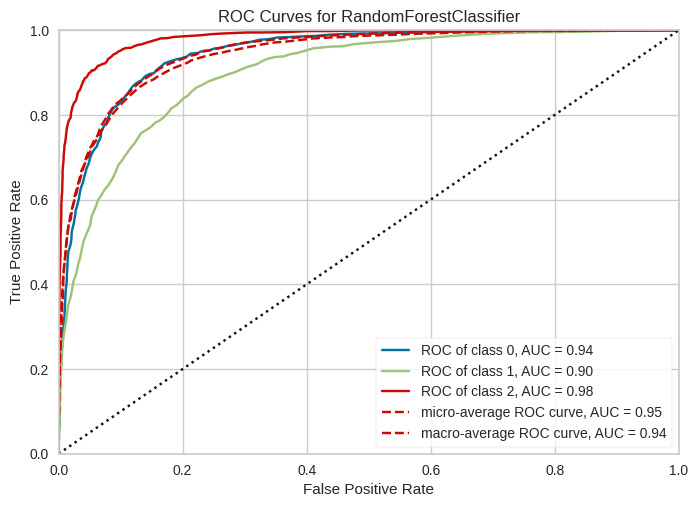

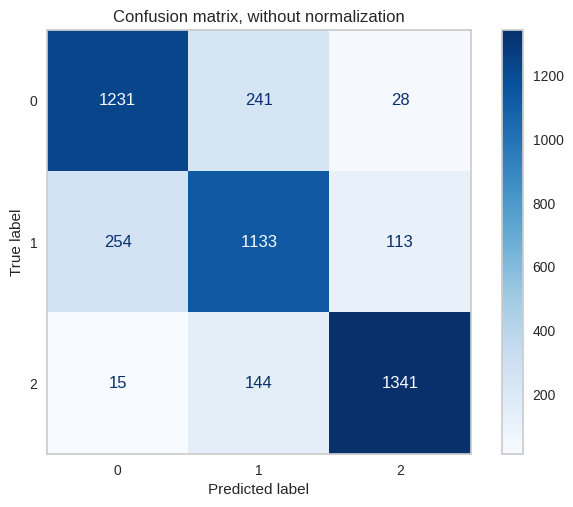

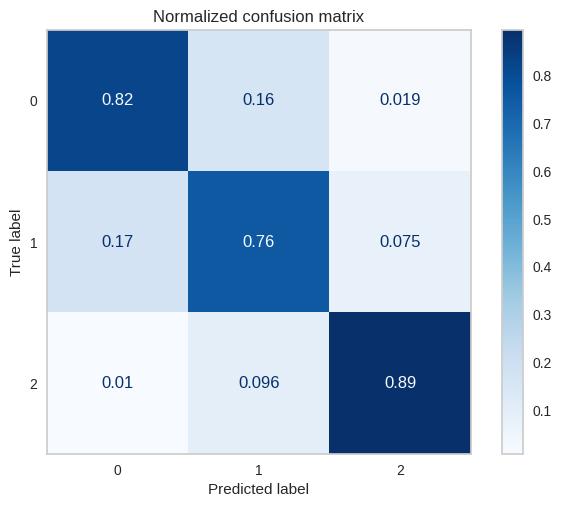

In [127]:
train_model_with_FE('RandomForestClassifier',X_train,y_train,X_test,y_test)

## Logistic Regresion

********************************************* WITHOUT FEATURE SELECTION **********************************************
Best Parameters:  {'C': 3.0, 'penalty': 'l2'}
Best Score:  0.7668571428571429
Standard Deviation:  0.007086123900090757
              precision    recall  f1-score   support

           0       0.77      0.75      0.76      1500
           1       0.63      0.68      0.66      1500
           2       0.87      0.83      0.85      1500

    accuracy                           0.75      4500
   macro avg       0.76      0.75      0.75      4500
weighted avg       0.76      0.75      0.75      4500



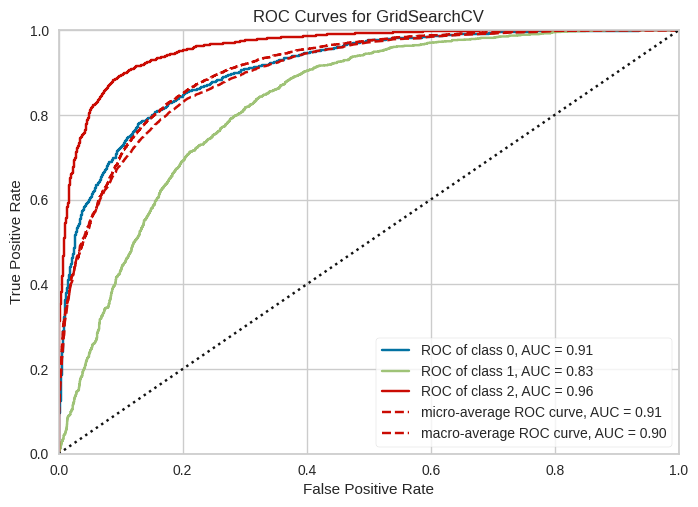

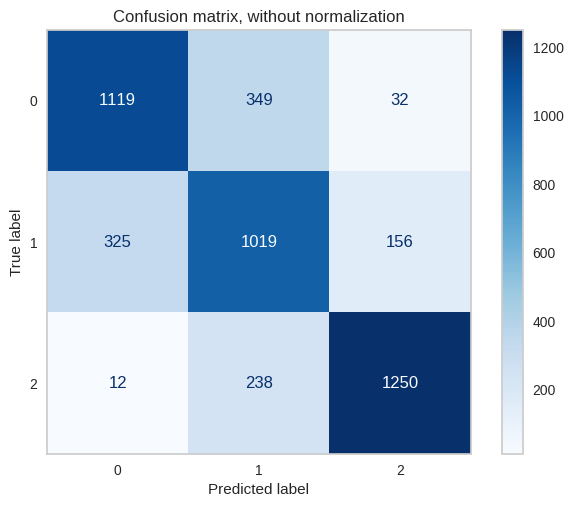

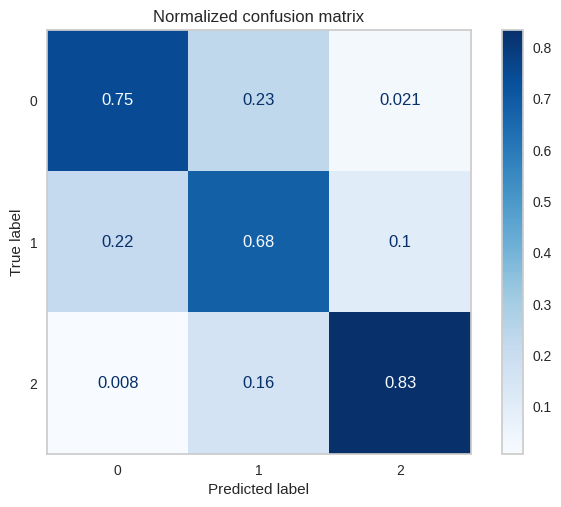

In [129]:
train_model_without_FE('LogisticRegression',X_train,y_train,X_test,y_test)

********************************************* WITH FEATURE SELECTION **********************************************
CatBoostClassifier = ['Glucose_lab', 'Age', 'Family_history', 'Albumin_urine_lab', 'Overweight', 'Sodium_lab', 'TC_LR_1Molar', 'Triglycerides_lab', 'BP_Sys', 'RBC_Count']

              precision    recall  f1-score   support

           0       0.74      0.74      0.74      1500
           1       0.61      0.65      0.63      1500
           2       0.87      0.82      0.84      1500

    accuracy                           0.74      4500
   macro avg       0.74      0.74      0.74      4500
weighted avg       0.74      0.74      0.74      4500



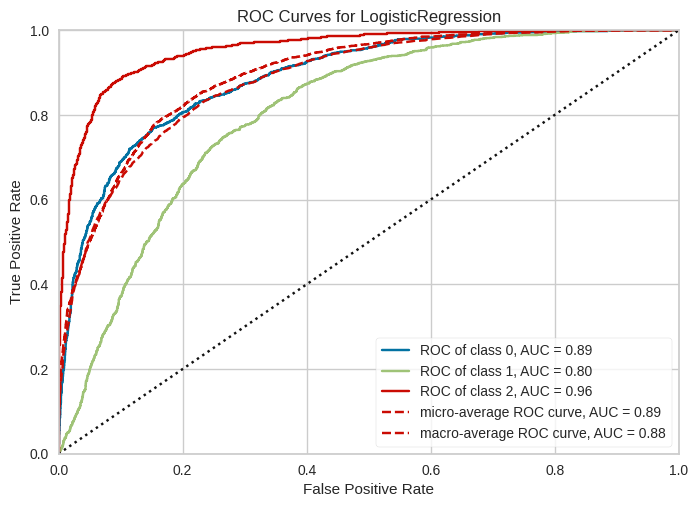

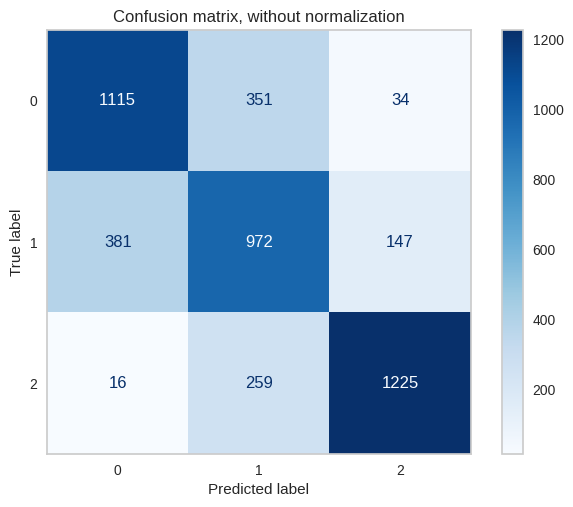

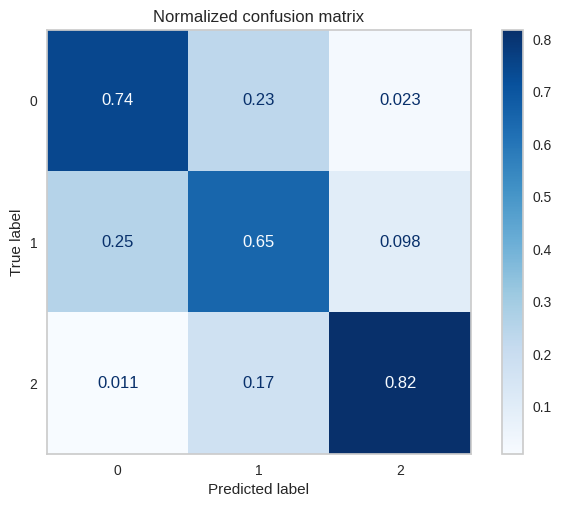

XGBClassifier = ['Glucose_lab', 'Age', 'Overweight', 'TC_LR_1Molar', 'Family_history', 'Gender', 'Abdominal_Diameter', 'Diet_Alcohol', 'Albumin_urine_lab', 'Ethnicity']

              precision    recall  f1-score   support

           0       0.75      0.74      0.74      1500
           1       0.63      0.67      0.65      1500
           2       0.87      0.82      0.85      1500

    accuracy                           0.74      4500
   macro avg       0.75      0.74      0.75      4500
weighted avg       0.75      0.74      0.75      4500



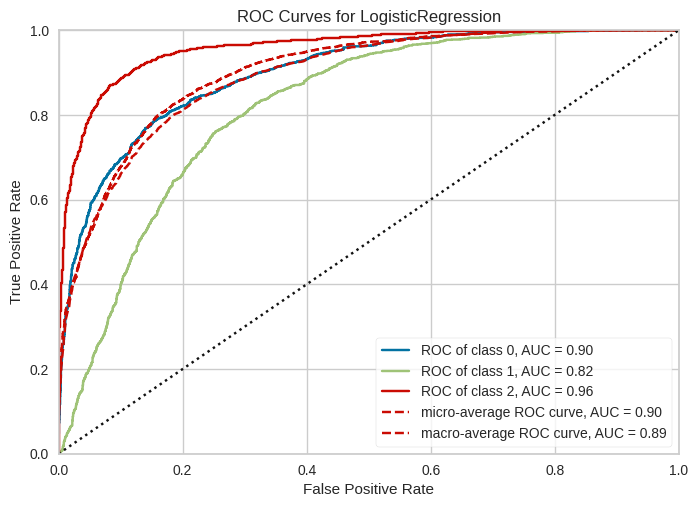

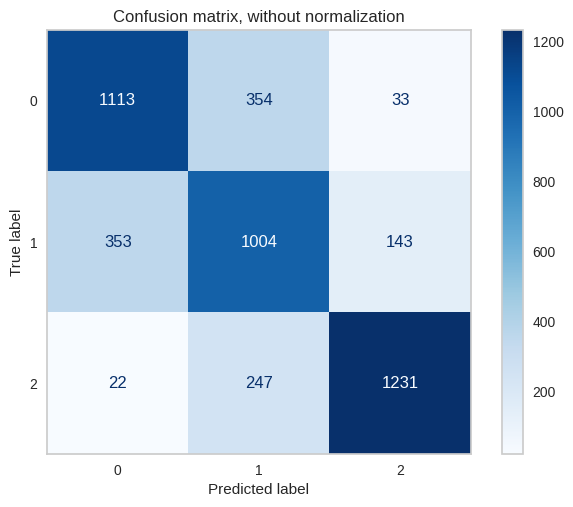

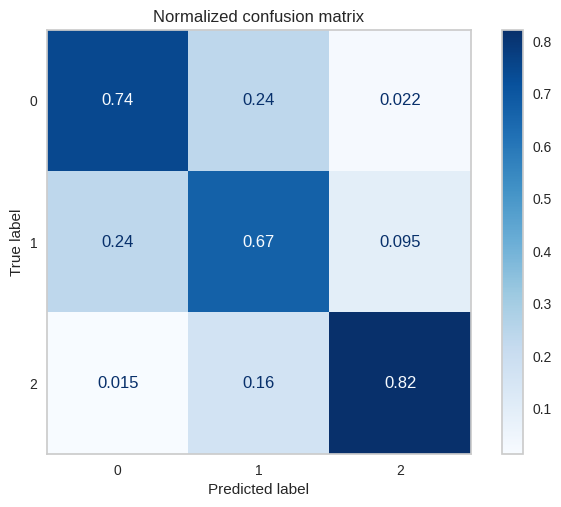

RandomForestClassifier = ['Glucose_lab', 'Age', 'Family_history', 'Abdominal_Diameter', 'Albumin_urine_lab', 'Waist_Circumference', 'TC_LR_1Molar', 'BP_Sys', 'Sodium_lab', 'Overweight']

              precision    recall  f1-score   support

           0       0.74      0.74      0.74      1500
           1       0.63      0.66      0.64      1500
           2       0.87      0.82      0.84      1500

    accuracy                           0.74      4500
   macro avg       0.74      0.74      0.74      4500
weighted avg       0.74      0.74      0.74      4500



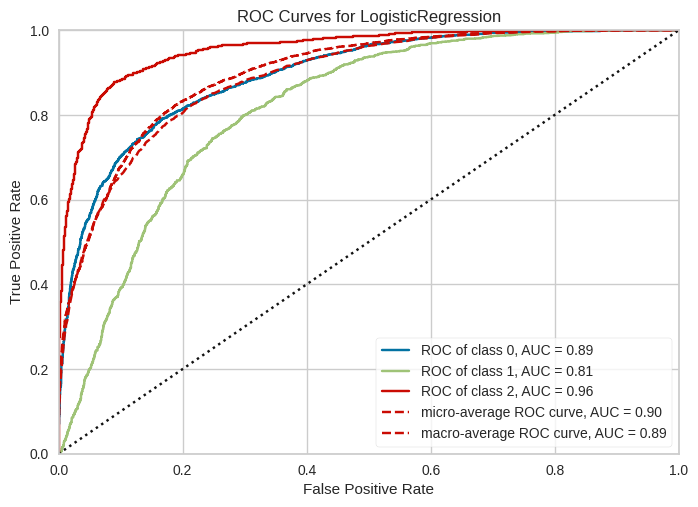

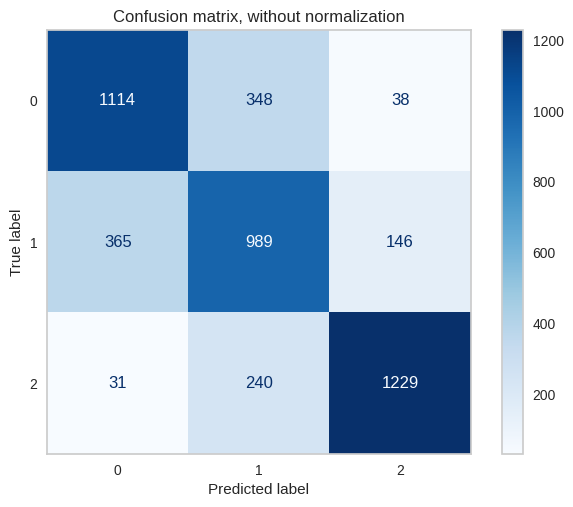

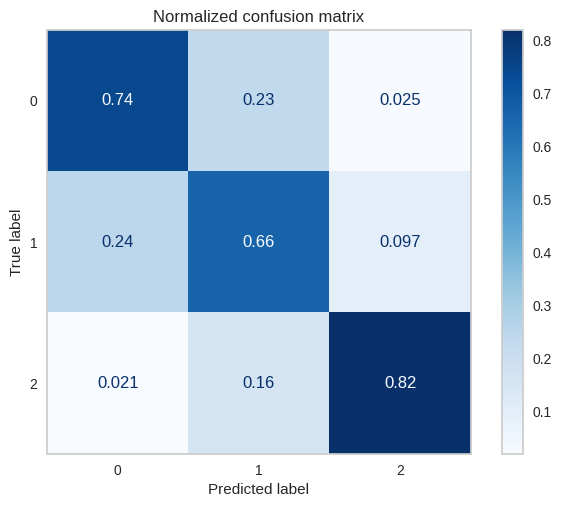

ExtraTreesClassifier = ['Glucose_lab', 'Age', 'Family_history', 'Abdominal_Diameter', 'TC_LR_1Molar', 'Waist_Circumference', 'Overweight', 'BP_Sys', 'Albumin_urine_lab', 'BMI']

              precision    recall  f1-score   support

           0       0.74      0.74      0.74      1500
           1       0.63      0.67      0.65      1500
           2       0.87      0.82      0.85      1500

    accuracy                           0.74      4500
   macro avg       0.75      0.74      0.75      4500
weighted avg       0.75      0.74      0.75      4500



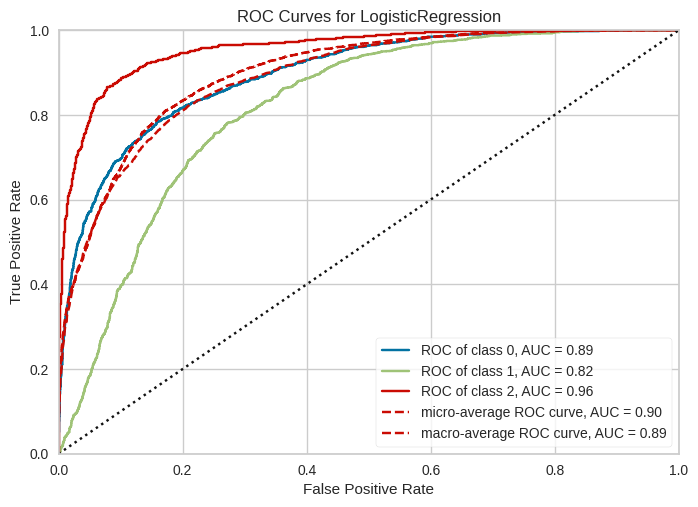

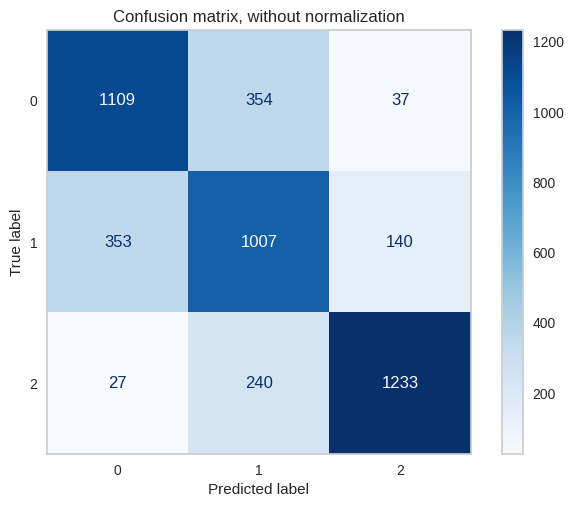

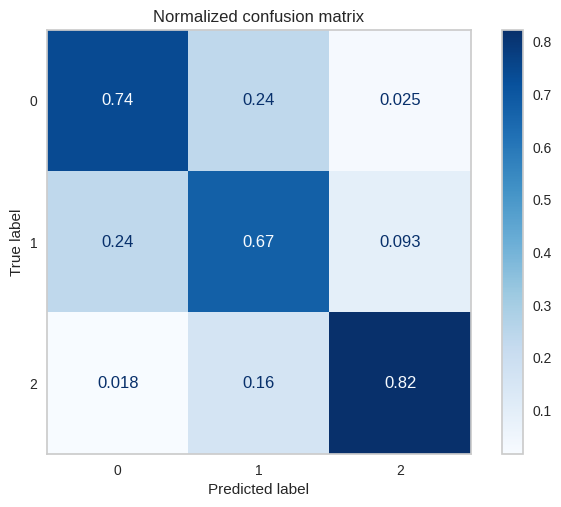

LogisticRegression = ['Glucose_lab', 'Iron_lab', 'Age', 'Abdominal_Diameter', 'Grip_Strength', 'Diet_Alcohol', 'BMI', 'RBC_Count', 'Diet_Caffiene', 'Diet_Sodium']

              precision    recall  f1-score   support

           0       0.75      0.74      0.75      1500
           1       0.62      0.67      0.64      1500
           2       0.87      0.82      0.84      1500

    accuracy                           0.74      4500
   macro avg       0.75      0.74      0.74      4500
weighted avg       0.75      0.74      0.74      4500



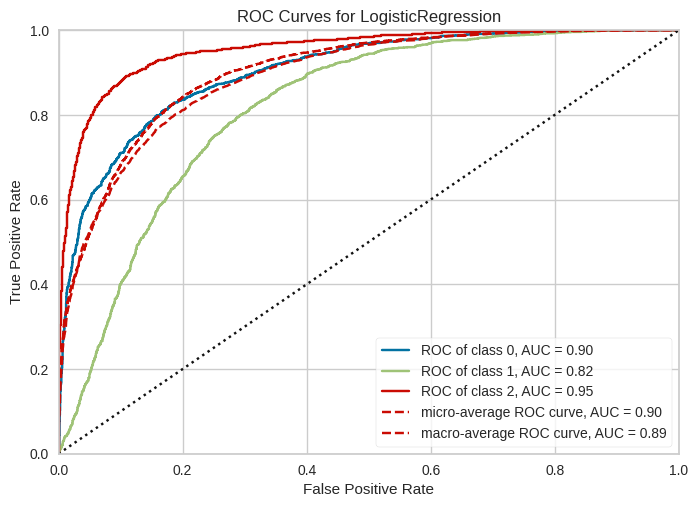

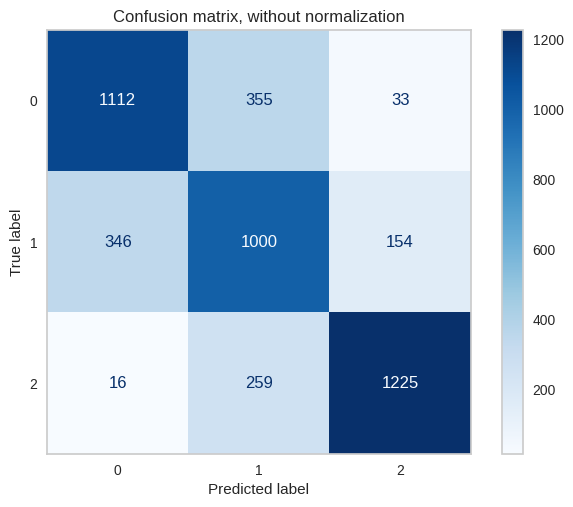

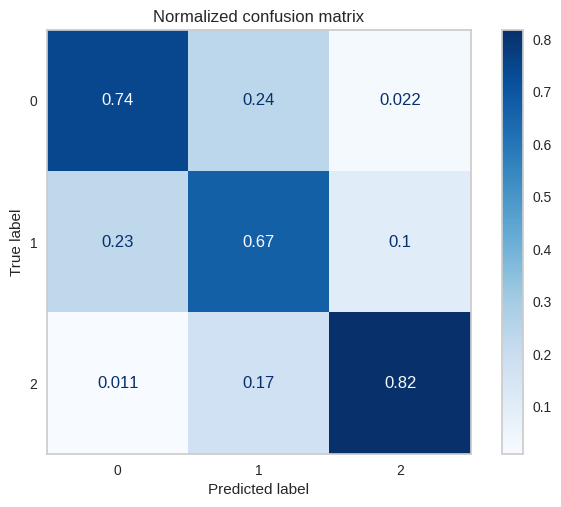

DecisionTreeClassifier_RFE = ['Glucose_lab', 'Family_history', 'Albumin_urine_lab', 'Diet_Calories', 'Diet_Poly_Fat', 'Iron_lab', 'Country_born', 'Triglycerides_lab', 'Diet_Fiber', 'Diet_Sugar']

              precision    recall  f1-score   support

           0       0.71      0.66      0.68      1500
           1       0.57      0.66      0.61      1500
           2       0.88      0.81      0.84      1500

    accuracy                           0.71      4500
   macro avg       0.72      0.71      0.71      4500
weighted avg       0.72      0.71      0.71      4500



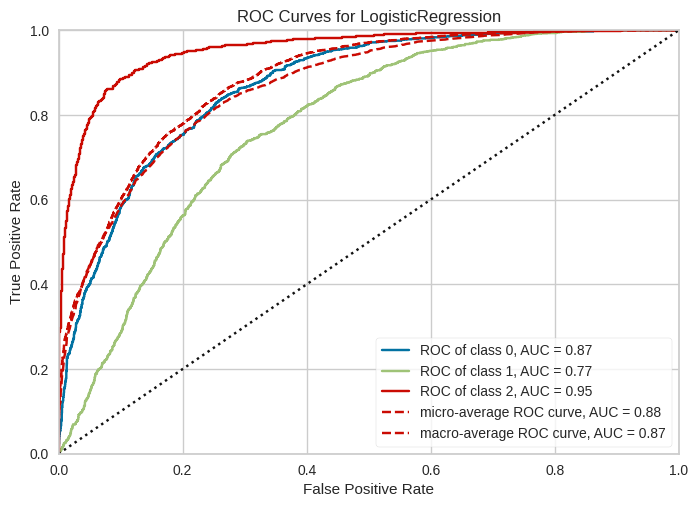

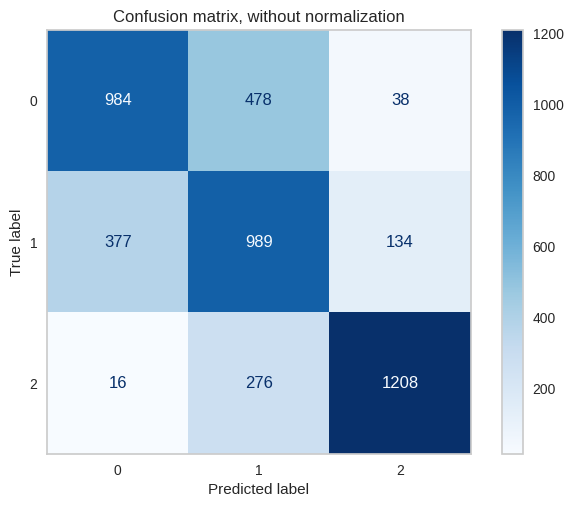

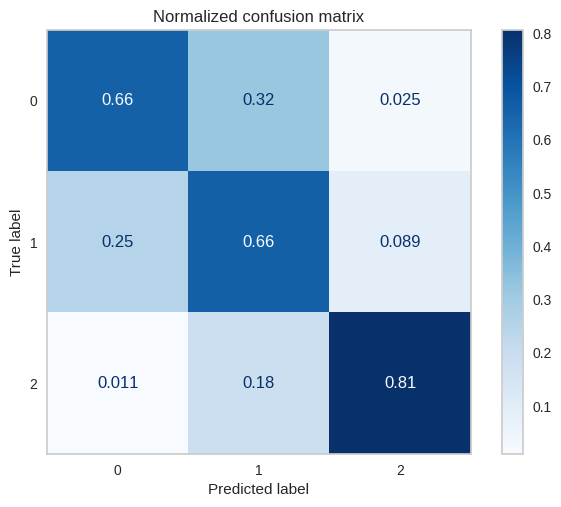

chi-squared = ['Family_history', 'Age', 'Overweight', 'Glucose_lab', 'TC_LR_1Molar', 'Gender', 'Abdominal_Diameter', 'Waist_Circumference', 'Albumin_urine_lab', 'BMI']

              precision    recall  f1-score   support

           0       0.75      0.73      0.74      1500
           1       0.62      0.68      0.65      1500
           2       0.87      0.82      0.85      1500

    accuracy                           0.74      4500
   macro avg       0.75      0.74      0.75      4500
weighted avg       0.75      0.74      0.75      4500



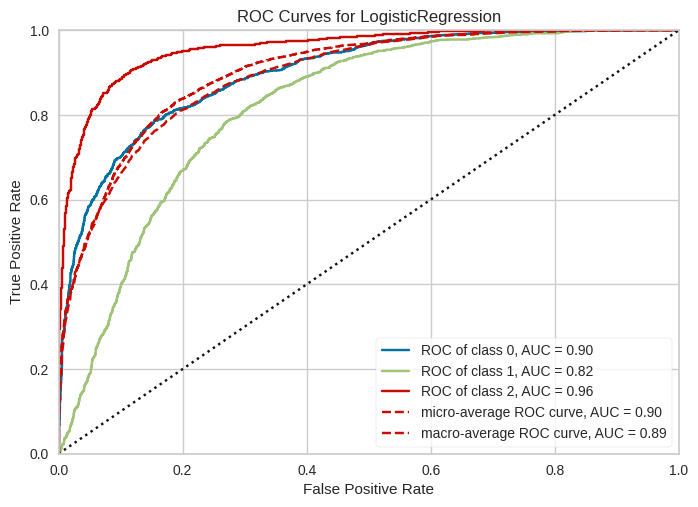

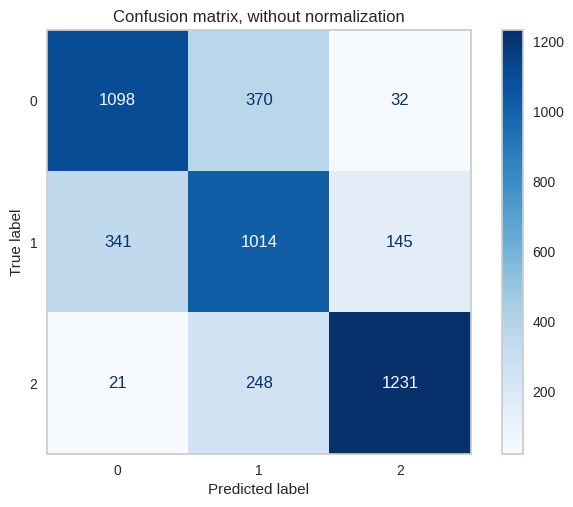

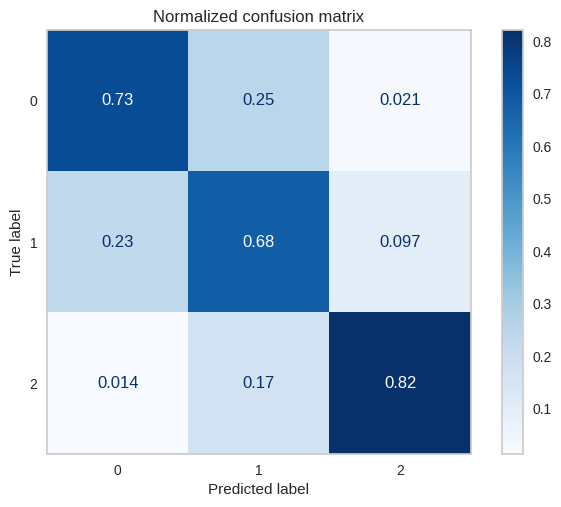

anova = ['Glucose_lab', 'Age', 'Abdominal_Diameter', 'Waist_Circumference', 'Family_history', 'BP_Sys', 'BMI', 'Overweight', 'Arm_Circumference', 'TC_LR_1Molar']

              precision    recall  f1-score   support

           0       0.74      0.73      0.74      1500
           1       0.63      0.67      0.65      1500
           2       0.87      0.83      0.85      1500

    accuracy                           0.74      4500
   macro avg       0.75      0.74      0.74      4500
weighted avg       0.75      0.74      0.74      4500



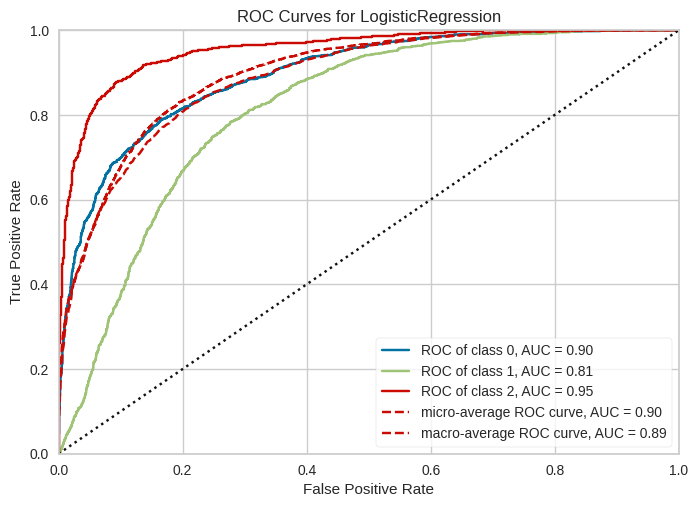

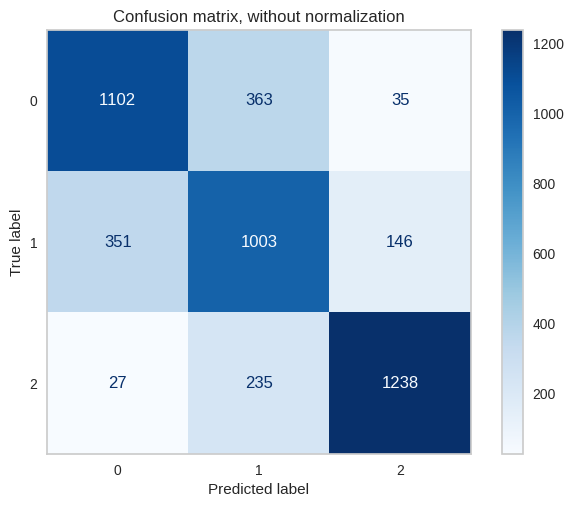

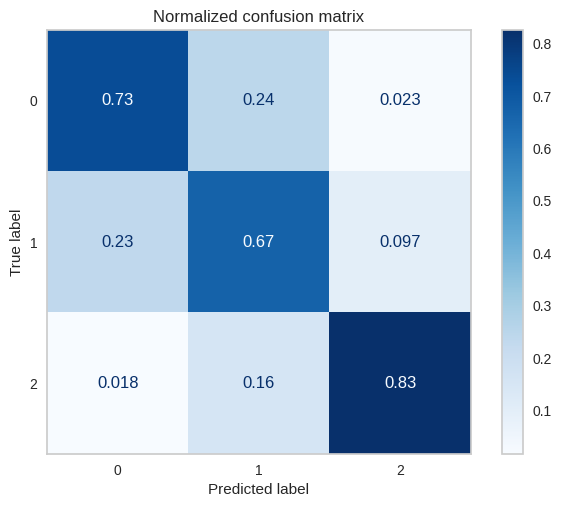

In [128]:
train_model_with_FE('LogisticRegression',X_train,y_train,X_test,y_test)

## SVM

********************************************* WITHOUT FEATURE SELECTION **********************************************
Best Parameters:  {'C': 3.0, 'kernel': 'poly'}
Best Score:  0.7960952380952381
Standard Deviation:  0.010619794976903928
              precision    recall  f1-score   support

           0       0.81      0.74      0.77      1500
           1       0.68      0.74      0.71      1500
           2       0.89      0.88      0.88      1500

    accuracy                           0.79      4500
   macro avg       0.79      0.79      0.79      4500
weighted avg       0.79      0.79      0.79      4500



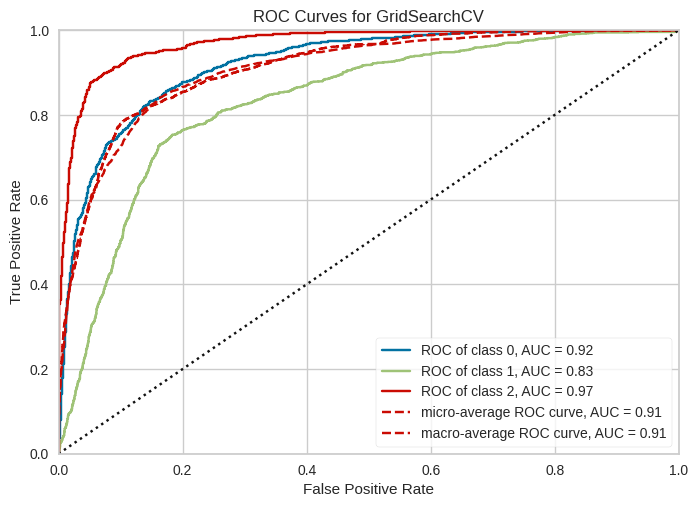

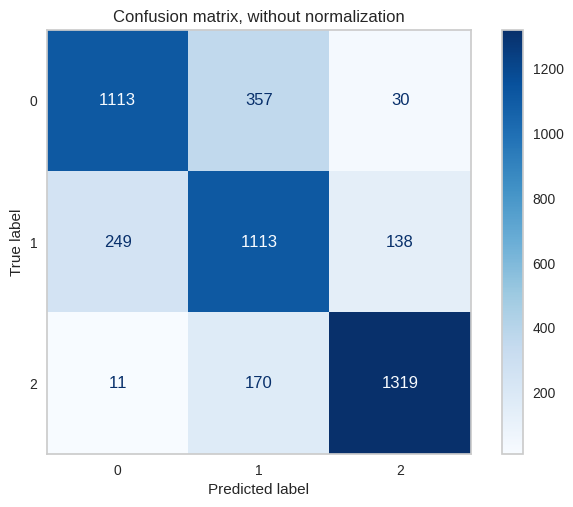

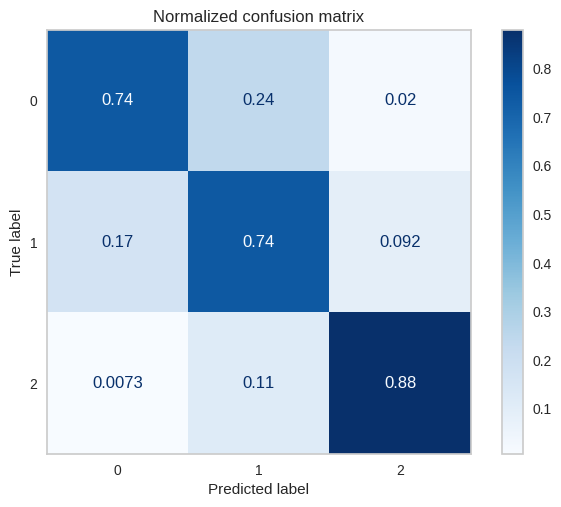

In [371]:
train_model_without_FE('SVM',X_train,y_train,X_test,y_test)

********************************************* WITH FEATURE SELECTION **********************************************
CatBoostClassifier = ['Glucose_lab', 'Age', 'Family_history', 'Albumin_urine_lab', 'Overweight', 'Sodium_lab', 'TC_LR_1Molar', 'Triglycerides_lab', 'BP_Sys', 'RBC_Count']

              precision    recall  f1-score   support

           0       0.76      0.75      0.76      1500
           1       0.64      0.69      0.66      1500
           2       0.88      0.82      0.85      1500

    accuracy                           0.75      4500
   macro avg       0.76      0.75      0.76      4500
weighted avg       0.76      0.75      0.76      4500



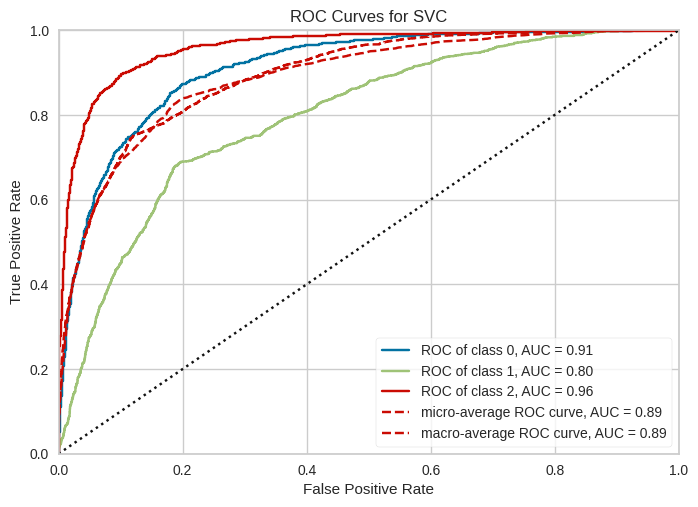

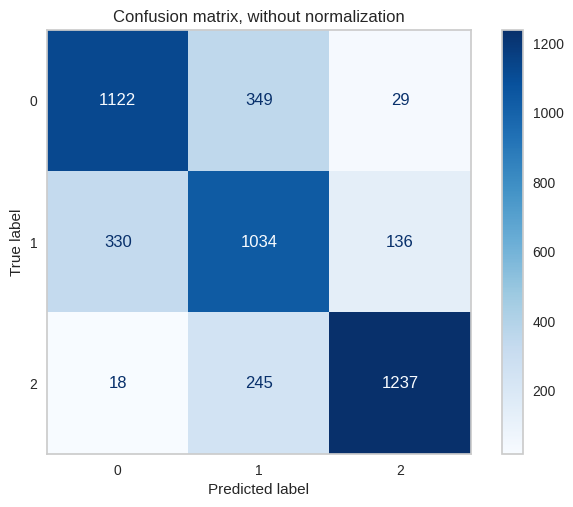

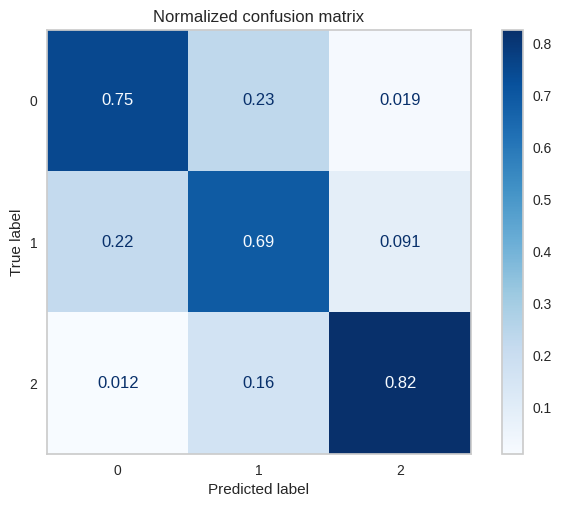

XGBClassifier = ['Glucose_lab', 'Age', 'Overweight', 'TC_LR_1Molar', 'Family_history', 'Gender', 'Abdominal_Diameter', 'Diet_Alcohol', 'Albumin_urine_lab', 'Ethnicity']

              precision    recall  f1-score   support

           0       0.76      0.78      0.77      1500
           1       0.65      0.69      0.67      1500
           2       0.89      0.82      0.85      1500

    accuracy                           0.76      4500
   macro avg       0.77      0.76      0.76      4500
weighted avg       0.77      0.76      0.76      4500



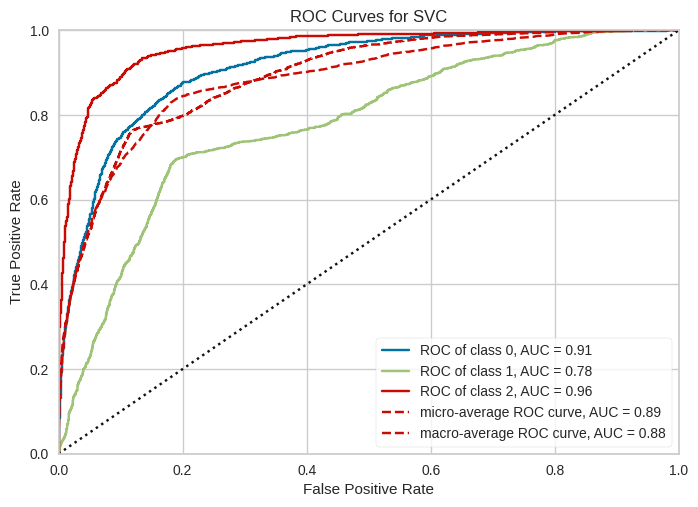

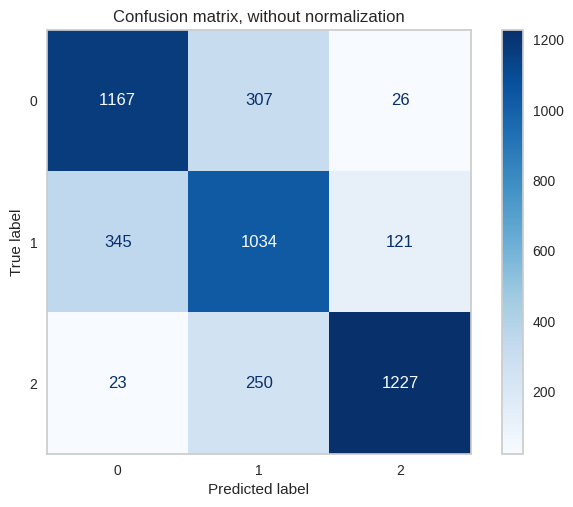

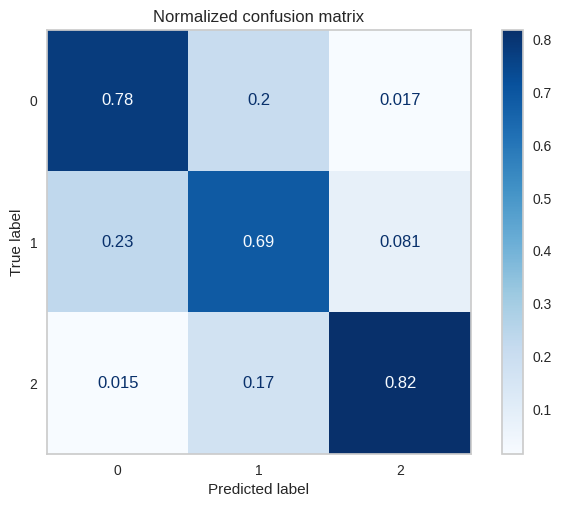

RandomForestClassifier = ['Glucose_lab', 'Age', 'Family_history', 'Abdominal_Diameter', 'Albumin_urine_lab', 'Waist_Circumference', 'TC_LR_1Molar', 'BP_Sys', 'Sodium_lab', 'Overweight']

              precision    recall  f1-score   support

           0       0.78      0.75      0.76      1500
           1       0.64      0.71      0.67      1500
           2       0.89      0.83      0.86      1500

    accuracy                           0.76      4500
   macro avg       0.77      0.76      0.76      4500
weighted avg       0.77      0.76      0.76      4500



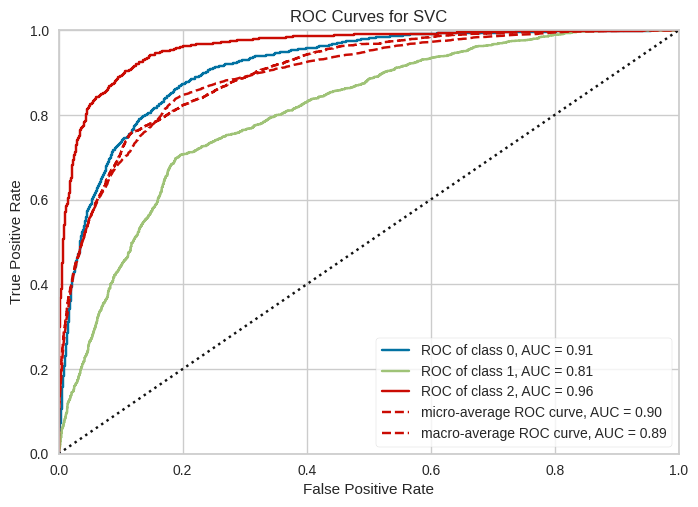

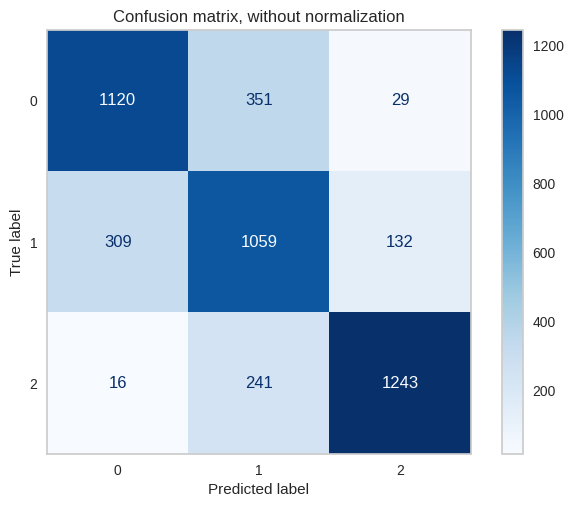

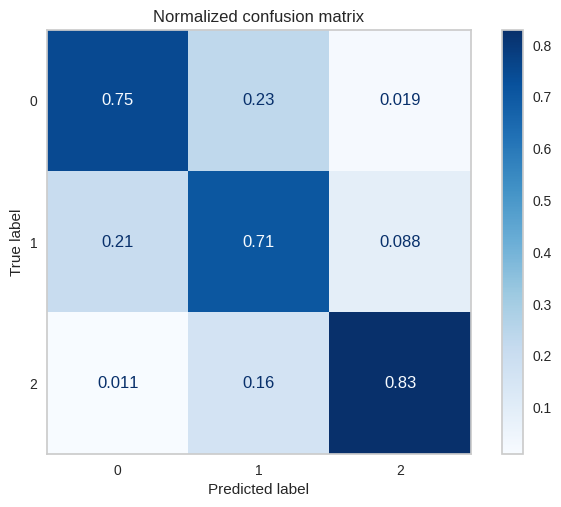

ExtraTreesClassifier = ['Glucose_lab', 'Age', 'Family_history', 'Abdominal_Diameter', 'TC_LR_1Molar', 'Waist_Circumference', 'Overweight', 'BP_Sys', 'Albumin_urine_lab', 'BMI']

              precision    recall  f1-score   support

           0       0.74      0.80      0.77      1500
           1       0.66      0.65      0.66      1500
           2       0.89      0.83      0.86      1500

    accuracy                           0.76      4500
   macro avg       0.76      0.76      0.76      4500
weighted avg       0.76      0.76      0.76      4500



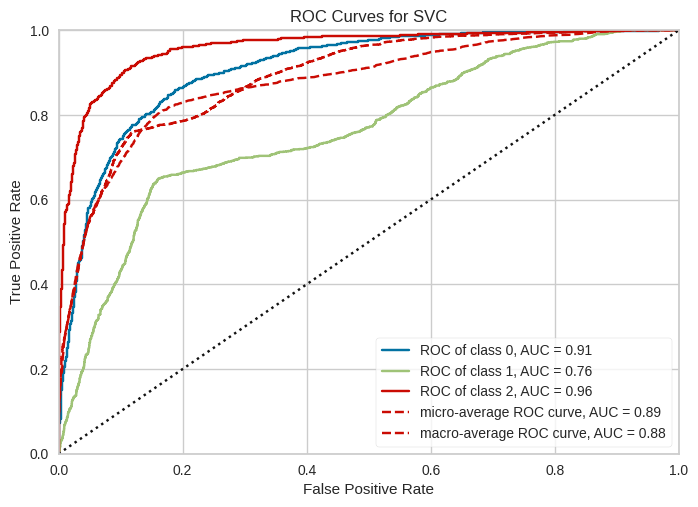

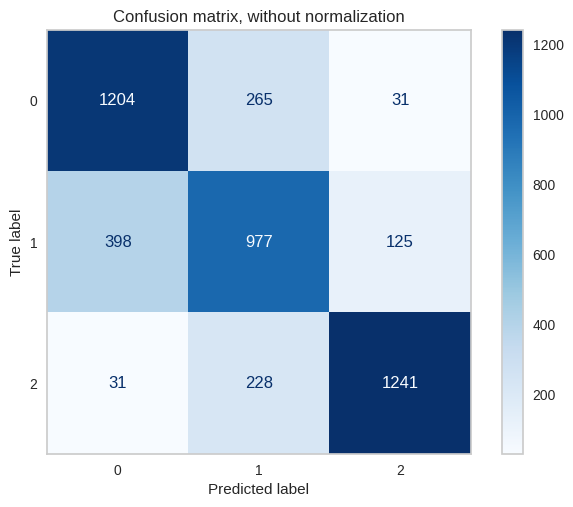

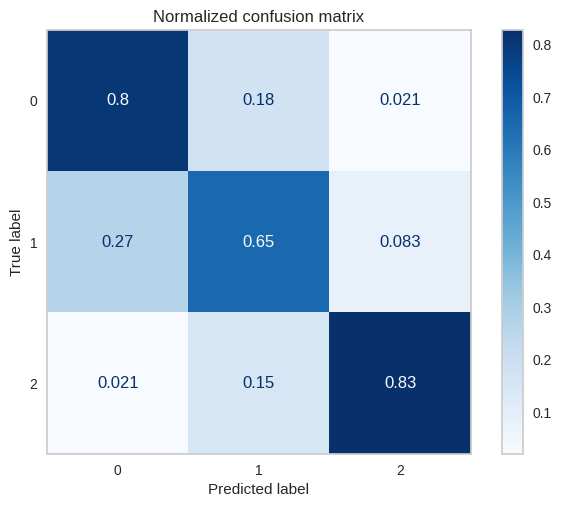

LogisticRegression = ['Glucose_lab', 'Iron_lab', 'Age', 'Abdominal_Diameter', 'Grip_Strength', 'Diet_Alcohol', 'BMI', 'RBC_Count', 'Diet_Caffiene', 'Diet_Sodium']

              precision    recall  f1-score   support

           0       0.76      0.77      0.76      1500
           1       0.65      0.68      0.67      1500
           2       0.89      0.82      0.86      1500

    accuracy                           0.76      4500
   macro avg       0.76      0.76      0.76      4500
weighted avg       0.76      0.76      0.76      4500



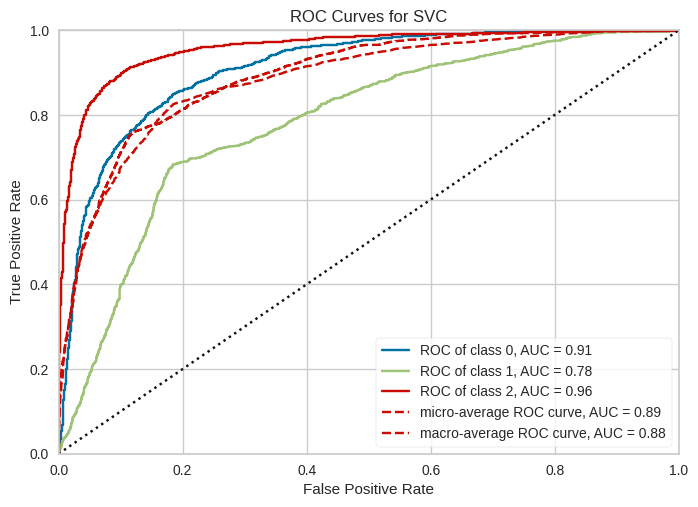

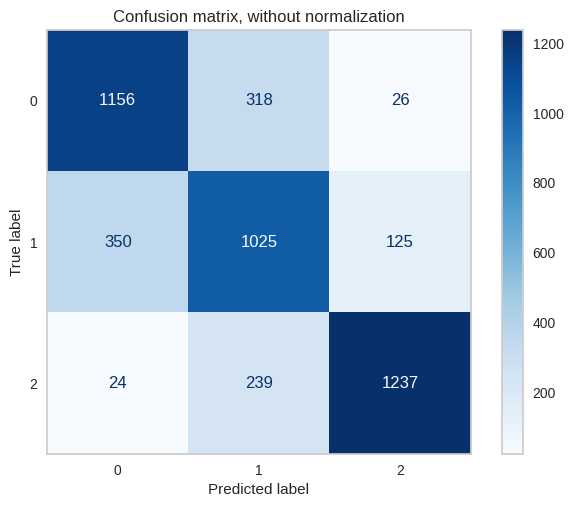

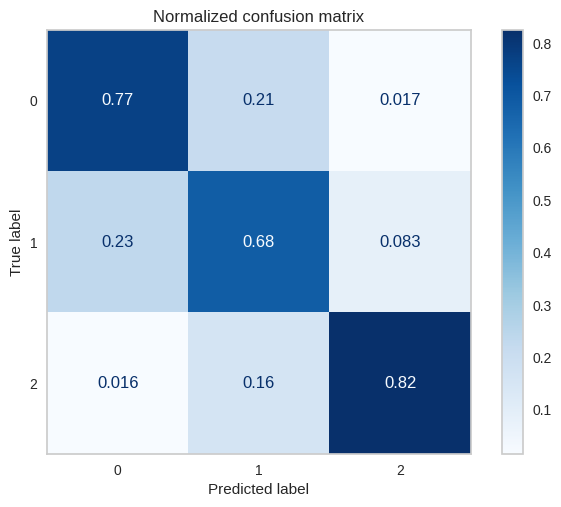

DecisionTreeClassifier_RFE = ['Glucose_lab', 'Family_history', 'Albumin_urine_lab', 'Diet_Calories', 'Diet_Poly_Fat', 'Iron_lab', 'Country_born', 'Triglycerides_lab', 'Diet_Fiber', 'Diet_Sugar']

              precision    recall  f1-score   support

           0       0.80      0.47      0.59      1500
           1       0.53      0.82      0.65      1500
           2       0.90      0.79      0.84      1500

    accuracy                           0.69      4500
   macro avg       0.74      0.69      0.69      4500
weighted avg       0.74      0.69      0.69      4500



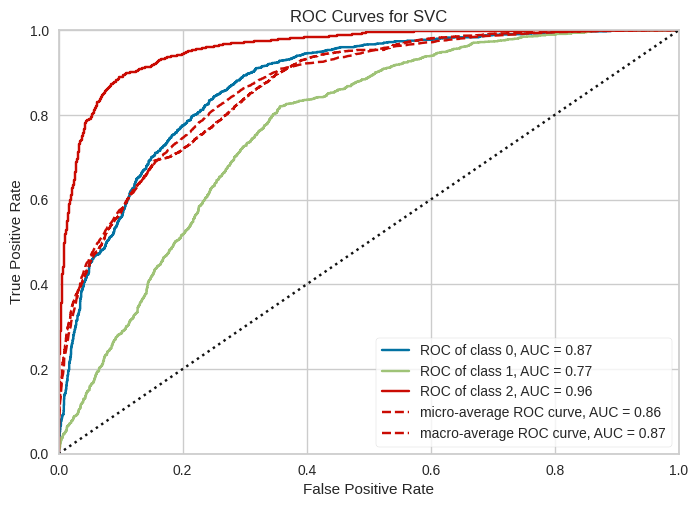

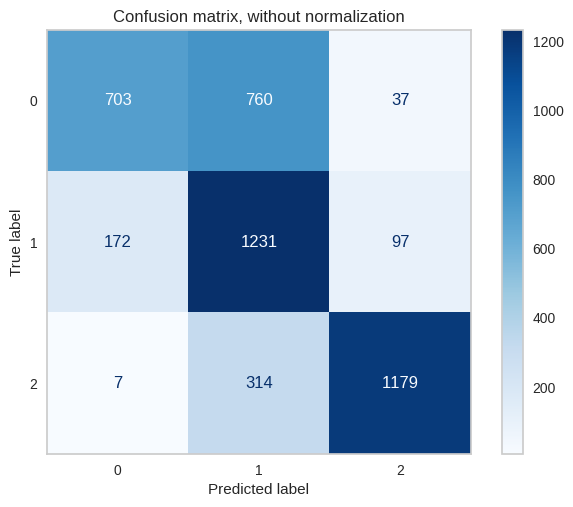

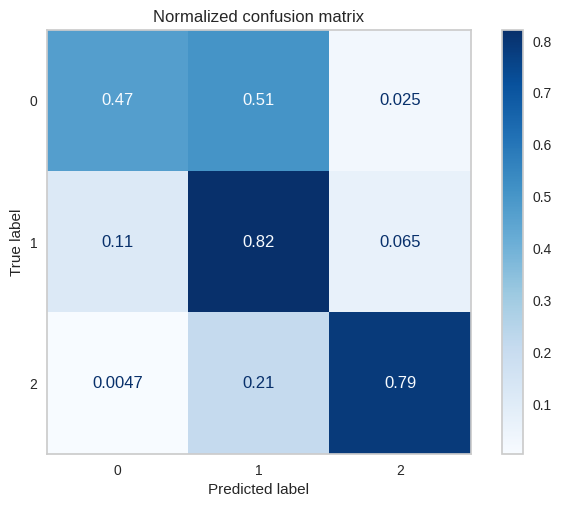

chi-squared = ['Family_history', 'Age', 'Overweight', 'Glucose_lab', 'TC_LR_1Molar', 'Gender', 'Abdominal_Diameter', 'Waist_Circumference', 'Albumin_urine_lab', 'BMI']

              precision    recall  f1-score   support

           0       0.75      0.78      0.76      1500
           1       0.65      0.68      0.67      1500
           2       0.89      0.82      0.85      1500

    accuracy                           0.76      4500
   macro avg       0.76      0.76      0.76      4500
weighted avg       0.76      0.76      0.76      4500



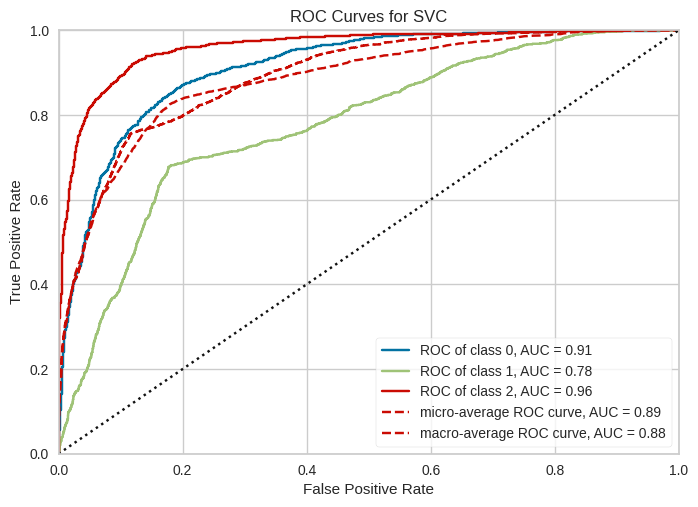

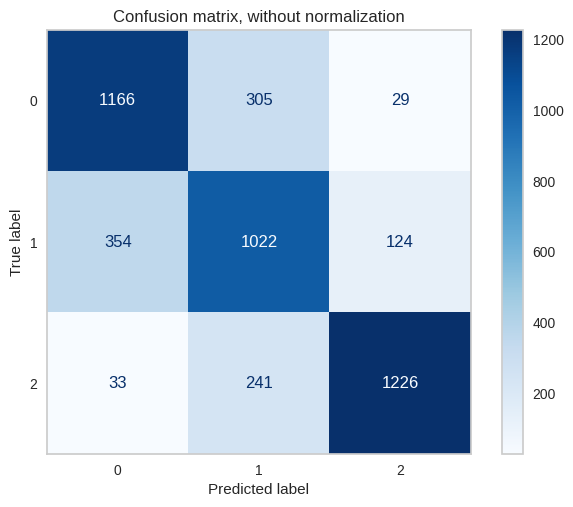

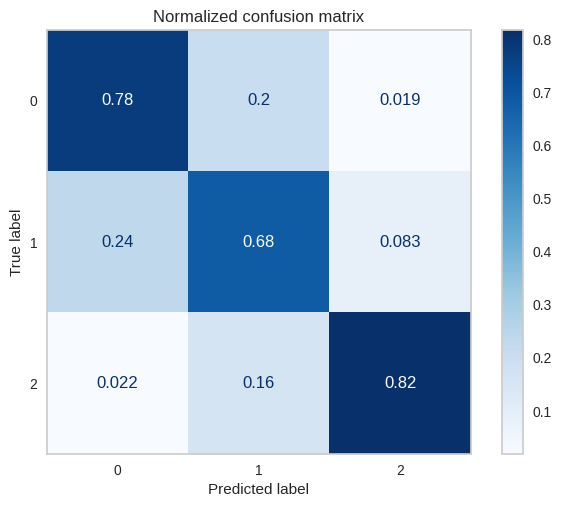

anova = ['Glucose_lab', 'Age', 'Abdominal_Diameter', 'Waist_Circumference', 'Family_history', 'BP_Sys', 'BMI', 'Overweight', 'Arm_Circumference', 'TC_LR_1Molar']

              precision    recall  f1-score   support

           0       0.74      0.79      0.76      1500
           1       0.65      0.64      0.65      1500
           2       0.88      0.83      0.85      1500

    accuracy                           0.75      4500
   macro avg       0.76      0.75      0.75      4500
weighted avg       0.76      0.75      0.75      4500



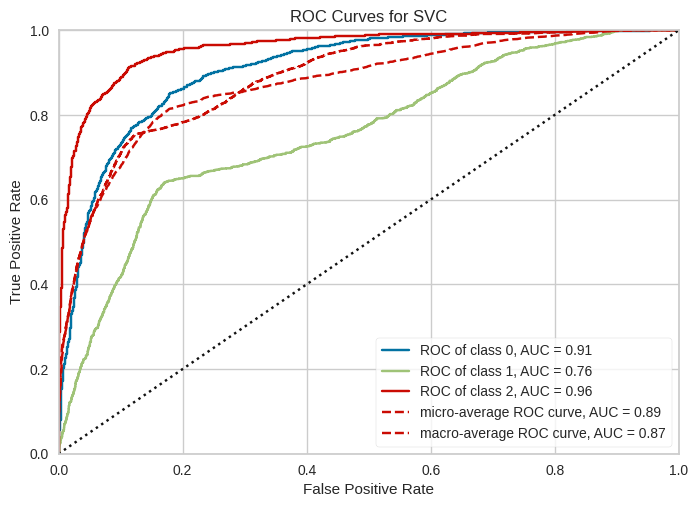

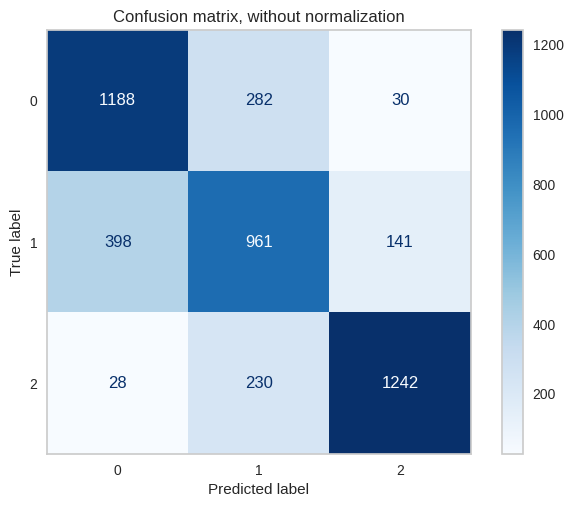

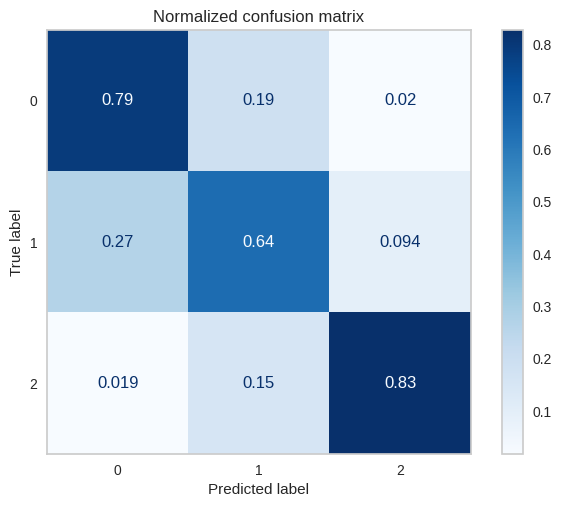

In [130]:
train_model_with_FE('SVM',X_train,y_train,X_test,y_test)

## KNN

********************************************* WITHOUT FEATURE SELECTION **********************************************
Best Parameters:  {'n_neighbors': 1}
Best Score:  0.8295238095238096
Standard Deviation:  0.006834619092574921
              precision    recall  f1-score   support

           0       0.88      0.71      0.79      1500
           1       0.75      0.84      0.79      1500
           2       0.89      0.97      0.93      1500

    accuracy                           0.84      4500
   macro avg       0.84      0.84      0.84      4500
weighted avg       0.84      0.84      0.84      4500



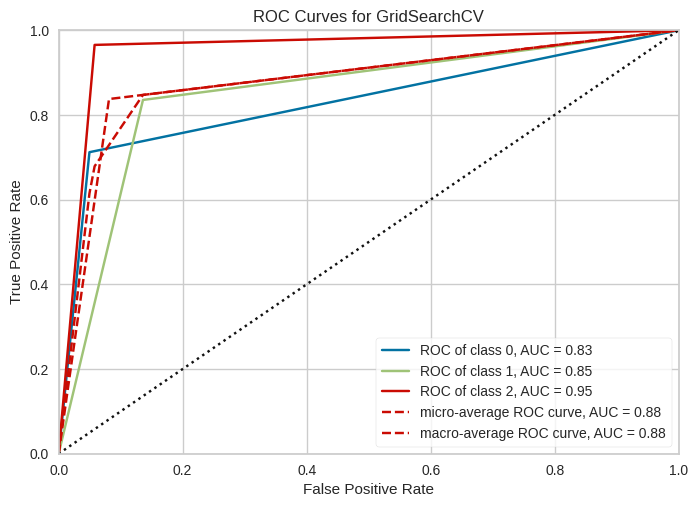

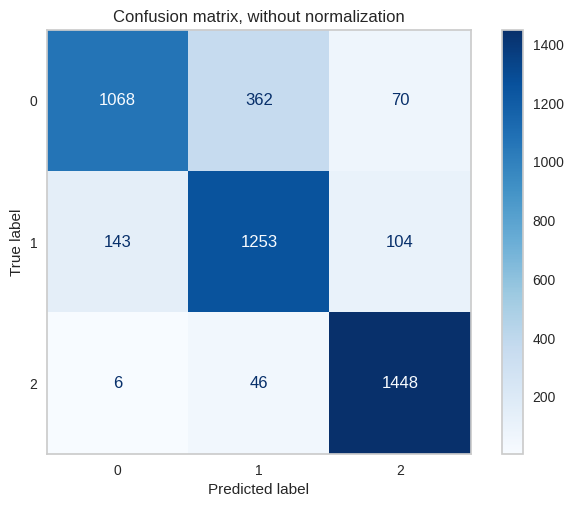

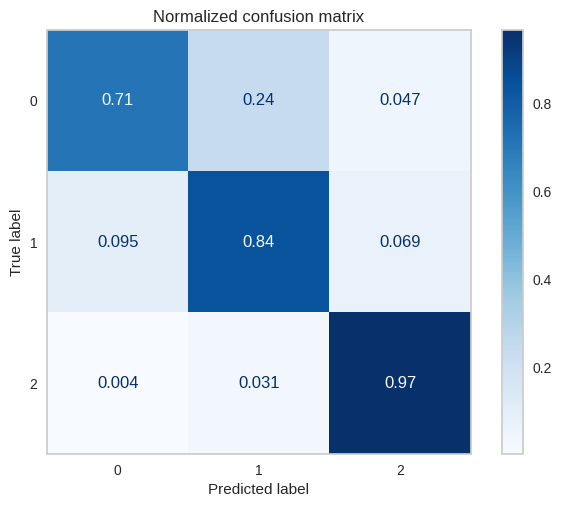

In [131]:
train_model_without_FE('KNN',X_train,y_train,X_test,y_test)

********************************************* WITH FEATURE SELECTION **********************************************
CatBoostClassifier = ['Glucose_lab', 'Age', 'Family_history', 'Albumin_urine_lab', 'Overweight', 'Sodium_lab', 'TC_LR_1Molar', 'Triglycerides_lab', 'BP_Sys', 'RBC_Count']

              precision    recall  f1-score   support

           0       0.80      0.73      0.76      1500
           1       0.71      0.73      0.72      1500
           2       0.88      0.92      0.90      1500

    accuracy                           0.80      4500
   macro avg       0.80      0.80      0.79      4500
weighted avg       0.80      0.80      0.79      4500



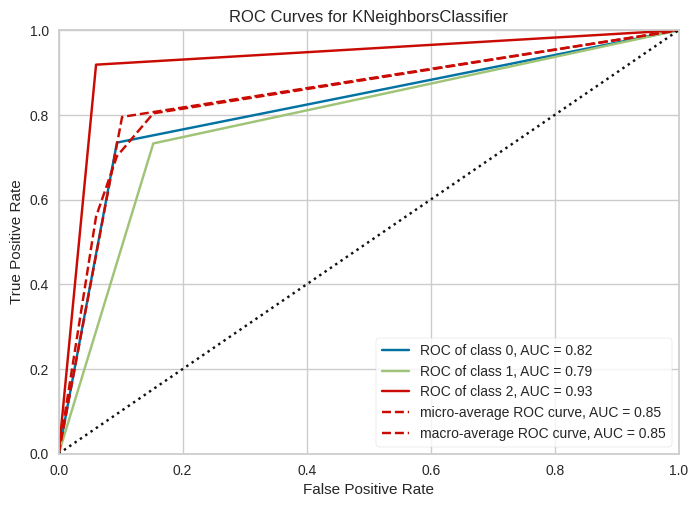

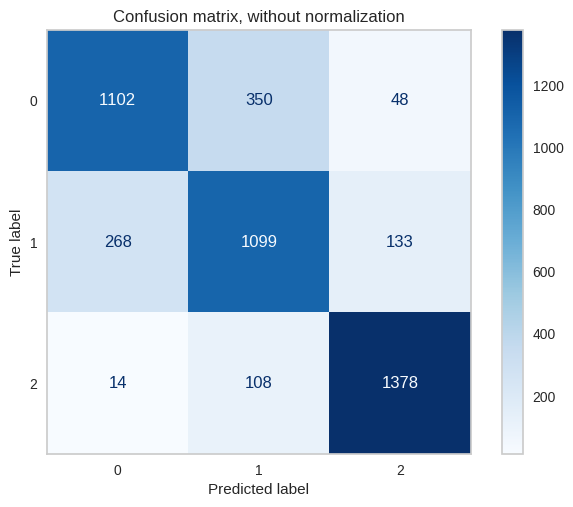

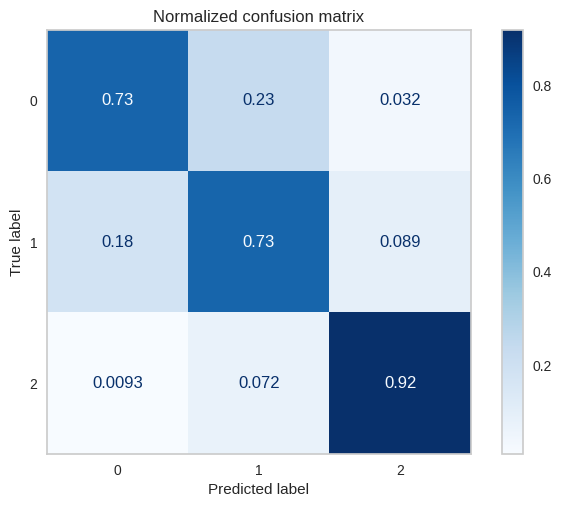

XGBClassifier = ['Glucose_lab', 'Age', 'Overweight', 'TC_LR_1Molar', 'Family_history', 'Gender', 'Abdominal_Diameter', 'Diet_Alcohol', 'Albumin_urine_lab', 'Ethnicity']

              precision    recall  f1-score   support

           0       0.76      0.75      0.75      1500
           1       0.66      0.66      0.66      1500
           2       0.85      0.86      0.85      1500

    accuracy                           0.76      4500
   macro avg       0.76      0.76      0.76      4500
weighted avg       0.76      0.76      0.76      4500



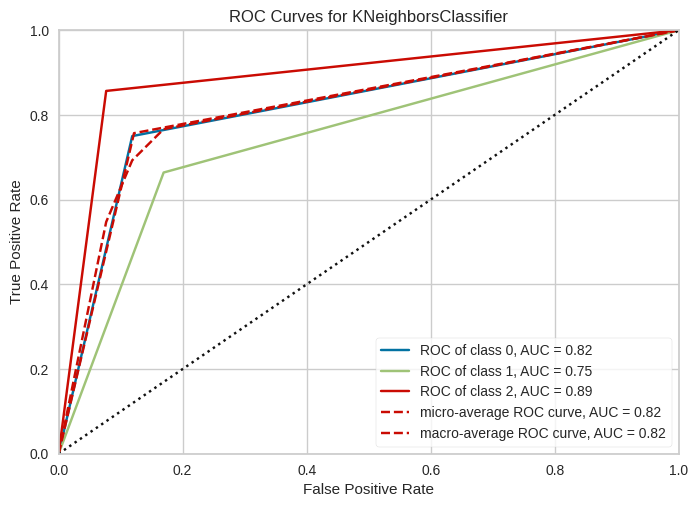

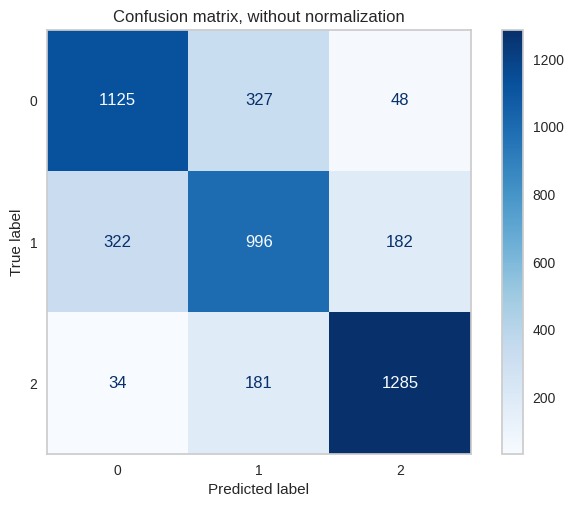

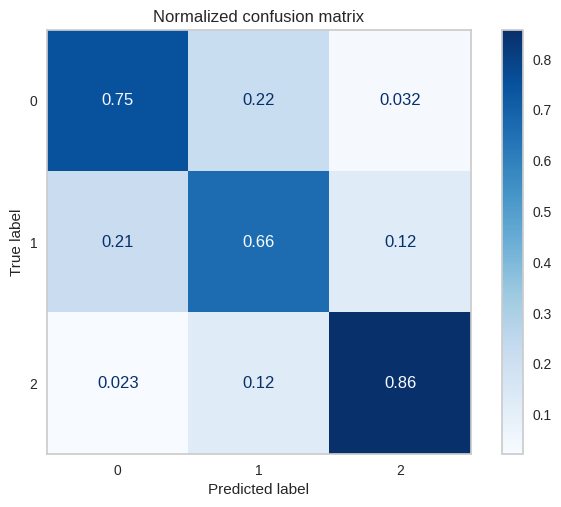

RandomForestClassifier = ['Glucose_lab', 'Age', 'Family_history', 'Abdominal_Diameter', 'Albumin_urine_lab', 'Waist_Circumference', 'TC_LR_1Molar', 'BP_Sys', 'Sodium_lab', 'Overweight']

              precision    recall  f1-score   support

           0       0.80      0.75      0.77      1500
           1       0.70      0.72      0.71      1500
           2       0.89      0.91      0.90      1500

    accuracy                           0.80      4500
   macro avg       0.80      0.80      0.80      4500
weighted avg       0.80      0.80      0.80      4500



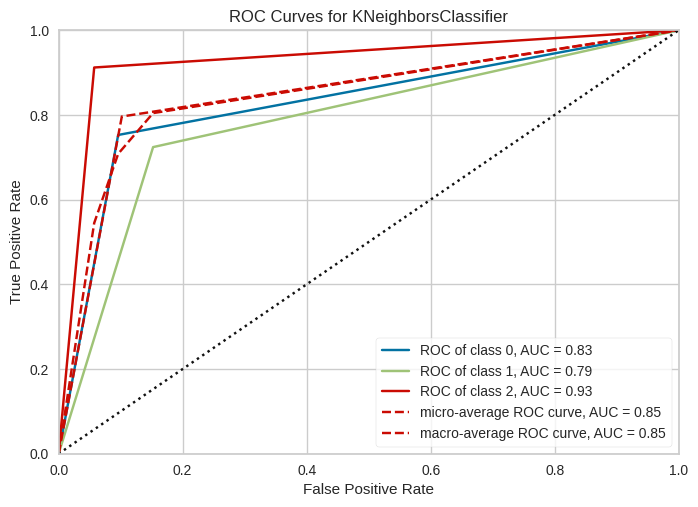

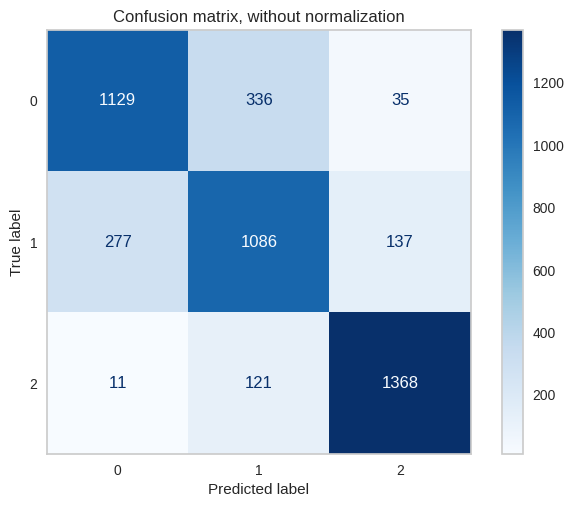

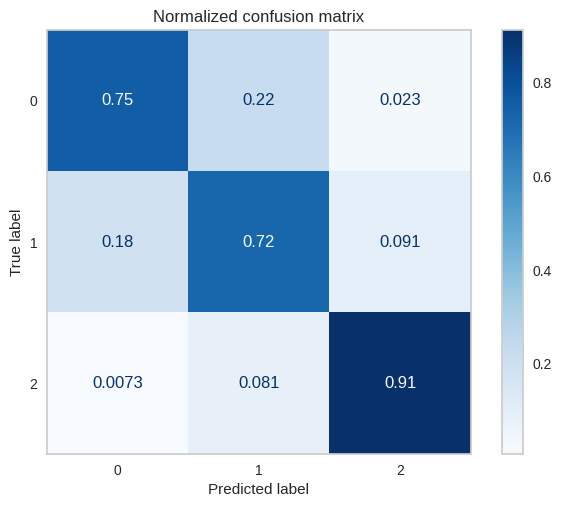

ExtraTreesClassifier = ['Glucose_lab', 'Age', 'Family_history', 'Abdominal_Diameter', 'TC_LR_1Molar', 'Waist_Circumference', 'Overweight', 'BP_Sys', 'Albumin_urine_lab', 'BMI']

              precision    recall  f1-score   support

           0       0.79      0.76      0.78      1500
           1       0.71      0.73      0.72      1500
           2       0.89      0.90      0.90      1500

    accuracy                           0.80      4500
   macro avg       0.80      0.80      0.80      4500
weighted avg       0.80      0.80      0.80      4500



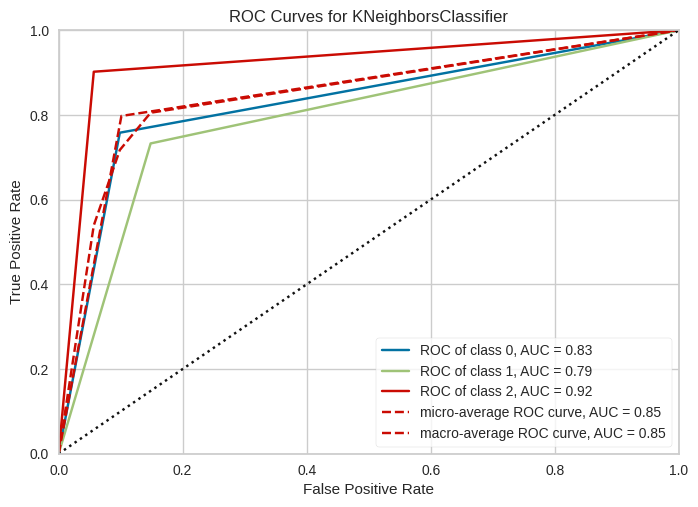

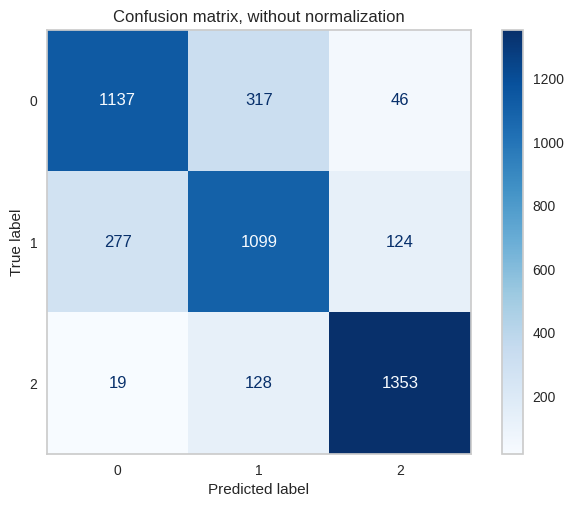

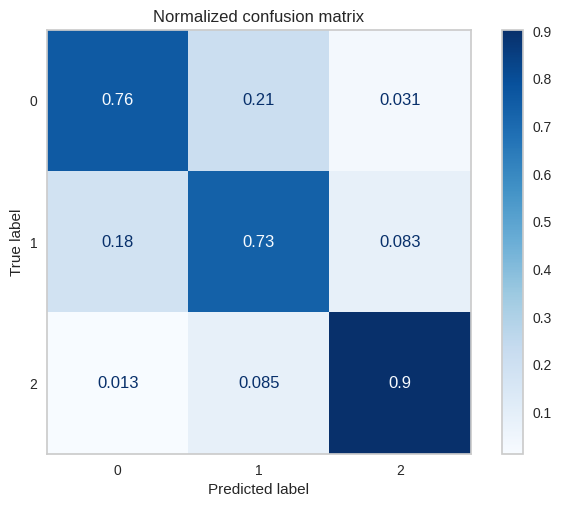

LogisticRegression = ['Glucose_lab', 'Iron_lab', 'Age', 'Abdominal_Diameter', 'Grip_Strength', 'Diet_Alcohol', 'BMI', 'RBC_Count', 'Diet_Caffiene', 'Diet_Sodium']

              precision    recall  f1-score   support

           0       0.84      0.70      0.77      1500
           1       0.72      0.81      0.76      1500
           2       0.91      0.94      0.93      1500

    accuracy                           0.82      4500
   macro avg       0.82      0.82      0.82      4500
weighted avg       0.82      0.82      0.82      4500



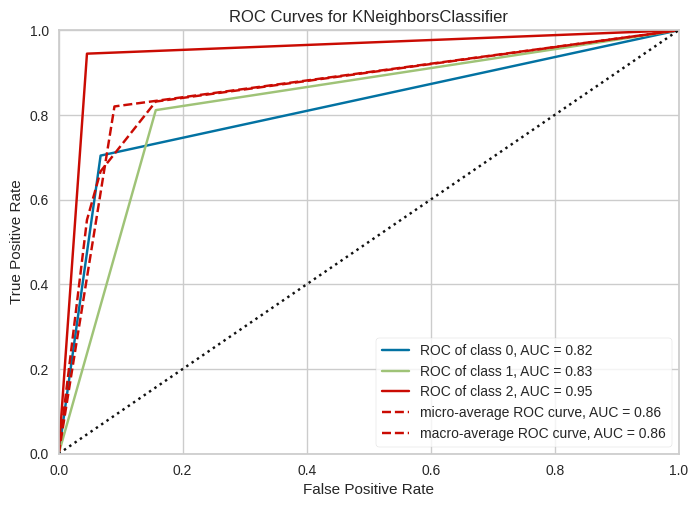

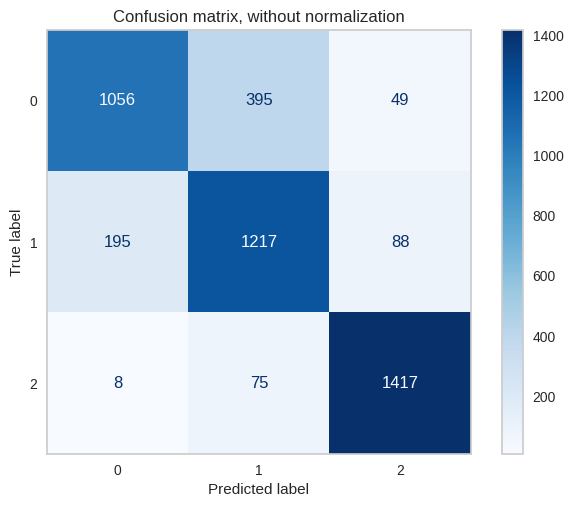

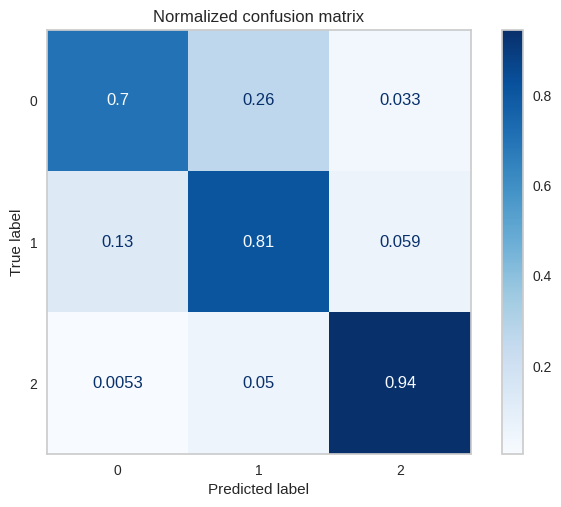

DecisionTreeClassifier_RFE = ['Glucose_lab', 'Family_history', 'Albumin_urine_lab', 'Diet_Calories', 'Diet_Poly_Fat', 'Iron_lab', 'Country_born', 'Triglycerides_lab', 'Diet_Fiber', 'Diet_Sugar']

              precision    recall  f1-score   support

           0       0.82      0.69      0.75      1500
           1       0.72      0.81      0.76      1500
           2       0.92      0.95      0.93      1500

    accuracy                           0.82      4500
   macro avg       0.82      0.82      0.82      4500
weighted avg       0.82      0.82      0.82      4500



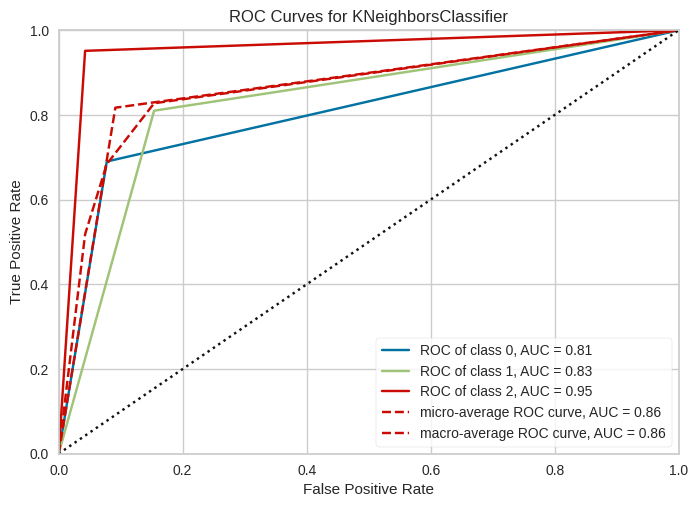

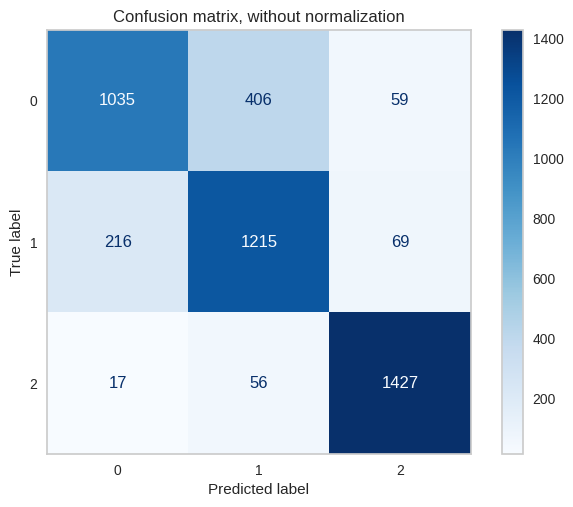

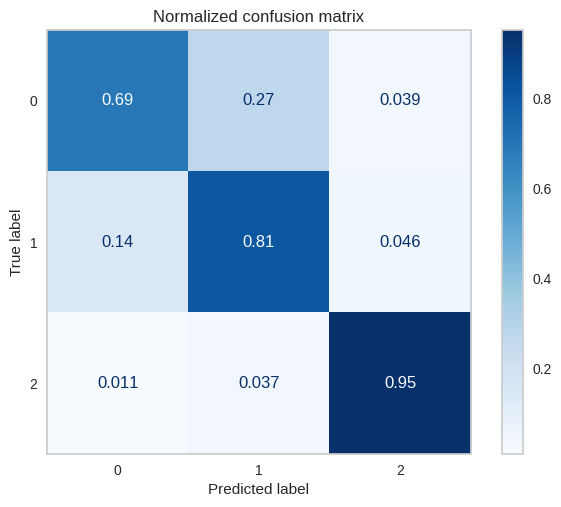

chi-squared = ['Family_history', 'Age', 'Overweight', 'Glucose_lab', 'TC_LR_1Molar', 'Gender', 'Abdominal_Diameter', 'Waist_Circumference', 'Albumin_urine_lab', 'BMI']

              precision    recall  f1-score   support

           0       0.76      0.73      0.74      1500
           1       0.68      0.69      0.68      1500
           2       0.87      0.88      0.88      1500

    accuracy                           0.77      4500
   macro avg       0.77      0.77      0.77      4500
weighted avg       0.77      0.77      0.77      4500



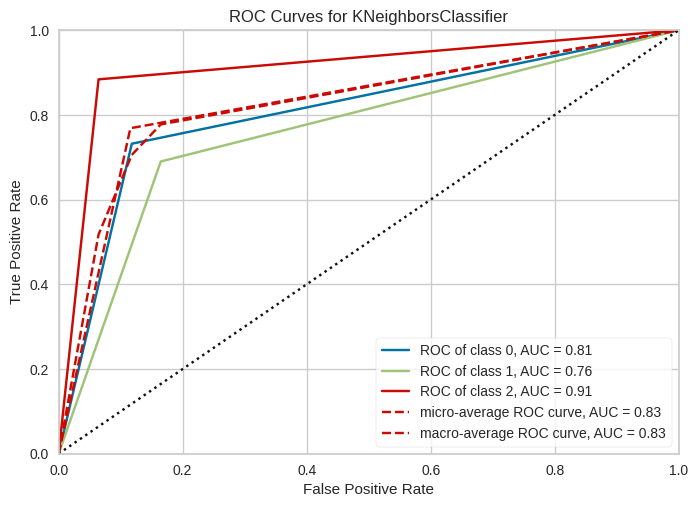

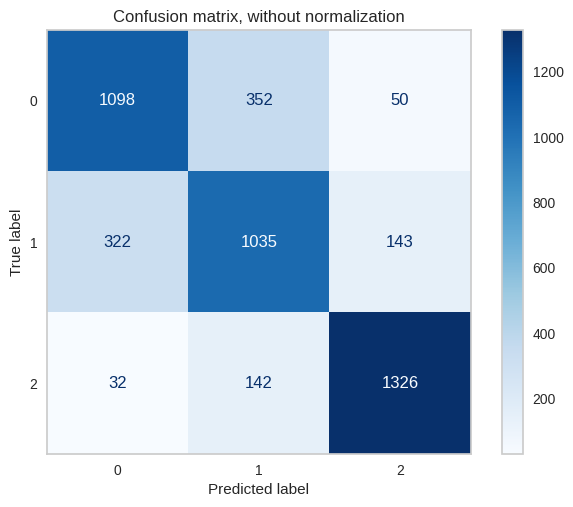

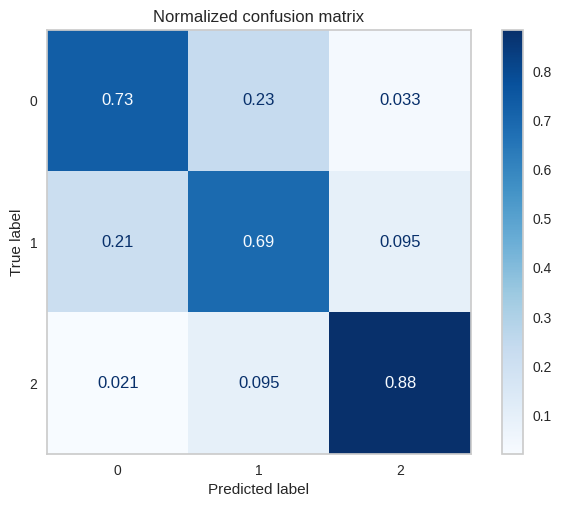

anova = ['Glucose_lab', 'Age', 'Abdominal_Diameter', 'Waist_Circumference', 'Family_history', 'BP_Sys', 'BMI', 'Overweight', 'Arm_Circumference', 'TC_LR_1Molar']

              precision    recall  f1-score   support

           0       0.80      0.73      0.76      1500
           1       0.71      0.74      0.72      1500
           2       0.88      0.91      0.90      1500

    accuracy                           0.80      4500
   macro avg       0.80      0.80      0.80      4500
weighted avg       0.80      0.80      0.80      4500



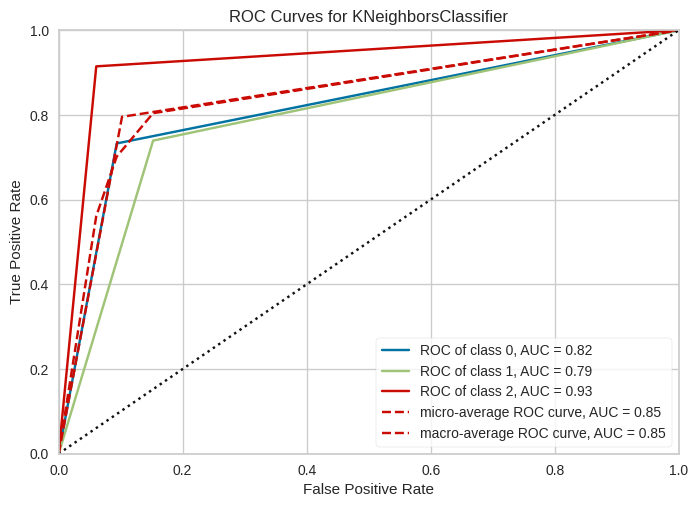

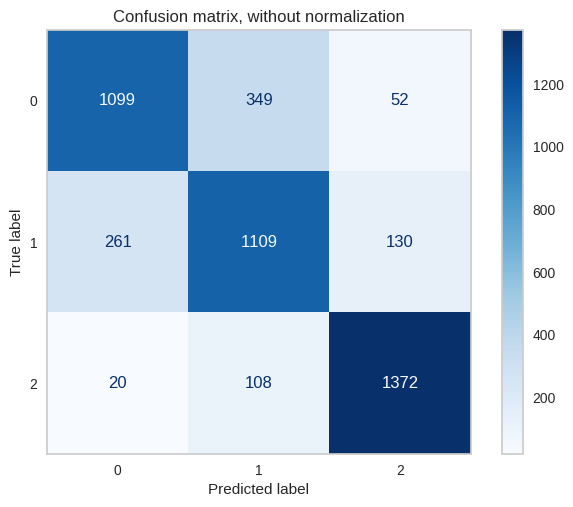

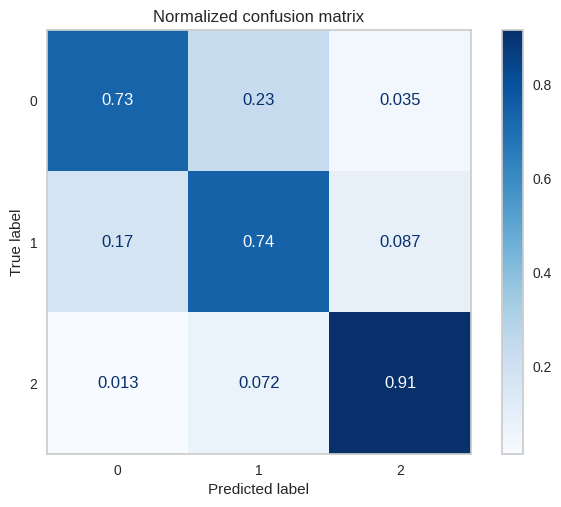

In [132]:
train_model_with_FE('KNN',X_train,y_train,X_test,y_test)